# Coefficent of Variation Jupyter Notebook

Python code to implement coefficient of variation (CV) for crop/non-crop classification using a Receiver Operating Characteristic (ROC) curve for a time-series of SAR images. The notebook statistically calculates the CV for a stack of time-series imagery. The CV output is then used to generate a ROC curve by using the USDA Cropland Data Layer (CDL) as ground truth. Pixels classified by the CDL as "Water" are masked and not used in classification because, water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this. The statistic Youden's Index is calculated to detemine the ideal threshold on the curve to use for best classification results. The accuracy of the classification compared to the CDL as ground truth are calculated for the CV crop/non-crop classification. The classified image is exported as a Geotiff. A CSV file is exported containing accuracy statistics for the classification.

Coefficient of Variation is calculated by: Standard Deviation/Mean

Created by: Shannon Rose, Microwave Remote Sensing Labratory (MIRSL) Unuversity of Massachusetts- Amherst

Datasets needed:

    Timeseries of SAR imagery
    
    CDL available at https://nassgeodata.gmu.edu/CropScape/

# Data Flow Model for Notebook

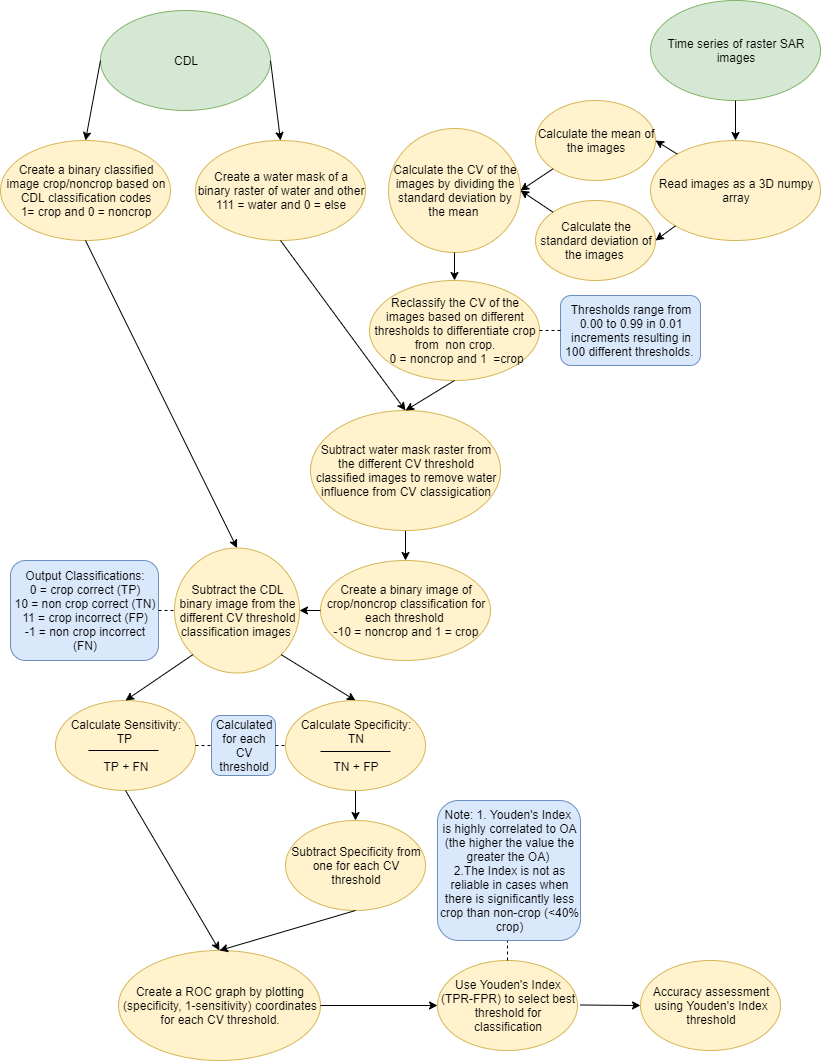

# Import Python Modules

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from osgeo import gdal, osr
import os
import pandas as pd
from pandas import DataFrame
from IPython.display import Image
import sklearn
from sklearn import metrics
from matplotlib.pyplot import figure
%matplotlib inline
import matplotlib.patches as mpatches

# Set the Input Parameters

Note: 
    1. For use in this notebook all raster datasets must be set to the same grid with pixels aligned
    2. The only data that can be in the set "SAR_image_folder" is the timeseries SAR imagery

In [2]:
SAR_image_folder = r'C:\Users\sjrose\Box\Shannon_Final_Deliverables\Final_CV_notebook_and_test_data\Sample_Sentinel1_Time_Series'
CDL_image_folder = r'C:\Users\sjrose\Box\Shannon_Final_Deliverables\Final_CV_notebook_and_test_data\Sample_CDL'
CDL = "CDL_Kansas_clip_prep.tif"

# Set the Output Parameters

In [3]:
Output_folder = r'C:\Users\sjrose\Box\Shannon_Final_Deliverables\Final_CV_notebook_and_test_data\Notebook_Outputs'
CV_classification_binary = "CV_classification_final.tif"
CV_classification_filename_with_accuracy = "CV_classification_with_accuracy.tif"
Accuracy_results = 'accuracy_statistics.csv'

# CDL Preparation

In [4]:
# Change working directory to bring in CDL
os.chdir(CDL_image_folder)

# Open CDL
rasterstack = gdal.Open(CDL).ReadAsArray()

# Get dimensions of CDL
first_raster_CDL = gdal.Open(CDL)
rows1 = first_raster_CDL.RasterYSize
cols1 = first_raster_CDL.RasterXSize

CDL_geotransform = first_raster_CDL.GetGeoTransform()
CDL_xres = CDL_geotransform[1]
CDL_yres = -CDL_geotransform[5]
CDL_xmin = CDL_geotransform[0]
CDL_ymax = CDL_geotransform[3]
CDL_spatialref = first_raster_CDL.GetProjectionRef()

Creating a mask to not include pixels in the CDL classified as "Water".
Water has a high variation measurement not comparable to the CV values of other non-cropland land covers and is often missclassified because of this.

The numeric classification value of "Water" in the CDL is 111.
The mask sets water (111 values) to 111 and everything else to 0.

Note: Additional masking can be completed outside of this notebook by classifying these areas in the CDL as 111 for use in this         notebook.
   Some pervious factors that were masked during classification to eliminate errors inherently present in the CDL:
       1. Pixels that are not surrounded by their same land cover type 
       2. Classified land areas smaller than two hectares in size

In [5]:
water_number = 111
watermask1 = rasterstack == water_number
watermask= np.multiply(rasterstack,watermask1)

#getting the number of pixels masked and not masked 
cdl111 = np.count_nonzero(watermask == 111)
print("Number of masked Pixels:", cdl111)
cdl0 = np.count_nonzero(watermask == 0)
print("Number of pixels for classification:", cdl0)
plt.imshow(rasterstack)

Number of masked Pixels: 1194426
Number of pixels for classification: 1899664


Creating a binary crop/non-crop classification from the CDL classified classes.

Crop classified to 1

Non-crop classified to 0

This can be customized by study area and what land use types are present there. 
To make a land class classified as non-crop simply place a "#" infront of the line of code for that land cover

In [6]:
CDL_crop = np.copy(rasterstack)
unique = np.unique(rasterstack)
uniquecount = len(unique)

#setting all crop classification values equal to 1 
CDL_crop[np.where(rasterstack== 1)]= 1    #Corn
CDL_crop[np.where(rasterstack== 2)]= 1    #Cotton
CDL_crop[np.where(rasterstack== 3)]= 1    #Rice
CDL_crop[np.where(rasterstack== 4)]= 1    #Sorghum
CDL_crop[np.where(rasterstack== 5)]= 1    #Soybeans
CDL_crop[np.where(rasterstack== 6)]= 1    #Sunflower
CDL_crop[np.where(rasterstack== 10)]= 1    #Peanuts
CDL_crop[np.where(rasterstack== 11)]= 1    #Tobacco
CDL_crop[np.where(rasterstack== 12)]= 1    #Sweet Corn
CDL_crop[np.where(rasterstack== 13)]= 1    #Pop or Orn Corn
CDL_crop[np.where(rasterstack== 14)]= 1    #Mint
CDL_crop[np.where(rasterstack== 21)]= 1    #Barley
CDL_crop[np.where(rasterstack== 22)]= 1    #Durum Wheat
CDL_crop[np.where(rasterstack== 23)]= 1    #Spring Wheat
CDL_crop[np.where(rasterstack== 24)]= 1    #Winter Wheat
CDL_crop[np.where(rasterstack== 25)]= 1    #Other small grains
CDL_crop[np.where(rasterstack== 26)]= 1    #Dbl crop WinWht/Soybeans
CDL_crop[np.where(rasterstack== 27)]= 1    #Rye
CDL_crop[np.where(rasterstack== 28)]= 1    #Oats
CDL_crop[np.where(rasterstack== 29)]= 1    #Millet
CDL_crop[np.where(rasterstack== 30)]= 1    #Speltz
CDL_crop[np.where(rasterstack== 31)]= 1    #Canola
CDL_crop[np.where(rasterstack== 32)]= 1    #Flaxseed
CDL_crop[np.where(rasterstack== 33)]= 1    #Safflower
CDL_crop[np.where(rasterstack== 34)]= 1    #Rape Seed
CDL_crop[np.where(rasterstack== 35)]= 1    #Mustard
CDL_crop[np.where(rasterstack== 36)]= 1    #Alfalfa
#CDL_crop[np.where(rasterstack== 37)]= 1    #Other Hay/Non Alfalfa---- could be omitted
CDL_crop[np.where(rasterstack== 38)]= 1    #Camelina
CDL_crop[np.where(rasterstack== 39)]= 1    #Buckwheat
CDL_crop[np.where(rasterstack== 41)]= 1    #Sugarbeets
CDL_crop[np.where(rasterstack== 42)]= 1    #Dry Beans
CDL_crop[np.where(rasterstack== 43)]= 1    #Potatoes
CDL_crop[np.where(rasterstack== 44)]= 1    #Other Crops
CDL_crop[np.where(rasterstack== 45)]= 1    #Sugarcane
CDL_crop[np.where(rasterstack== 46)]= 1    #Sweet Potatoes
CDL_crop[np.where(rasterstack== 47)]= 1    #Misc Vegs & Fruits
CDL_crop[np.where(rasterstack== 48)]= 1    #Watermelons
CDL_crop[np.where(rasterstack== 49)]= 1    #Onions
CDL_crop[np.where(rasterstack== 50)]= 1    #Cucumbers
CDL_crop[np.where(rasterstack== 51)]= 1    #Chick Peas
CDL_crop[np.where(rasterstack== 52)]= 1    #Lentils
CDL_crop[np.where(rasterstack== 53)]= 1    #Peas
CDL_crop[np.where(rasterstack== 54)]= 1    #Tomatoes
CDL_crop[np.where(rasterstack== 55)]= 1    #Cranberries
CDL_crop[np.where(rasterstack== 56)]= 1    #Hops
CDL_crop[np.where(rasterstack== 57)]= 1    #Herbs
CDL_crop[np.where(rasterstack== 58)]= 1    #Clover/Wildflowers
#CDL_crop[np.where(rasterstack== 59)]= 1    #Sod/Grass Seed---- could be omitted
#CDL_crop[np.where(rasterstack== 60)]= 1    #Switchgrass---- could be omitted
CDL_crop[np.where(rasterstack== 61)]= 1    #Fallow/Idle Cropland
CDL_crop[np.where(rasterstack== 66)]= 1    #Cherries
CDL_crop[np.where(rasterstack== 67)]= 1    #Peaches
CDL_crop[np.where(rasterstack== 68)]= 1    #Apples
CDL_crop[np.where(rasterstack== 69)]= 1    #Grapes
CDL_crop[np.where(rasterstack== 70)]= 1    #Christmas Trees
CDL_crop[np.where(rasterstack== 71)]= 1    #Other Tree Crops    
CDL_crop[np.where(rasterstack== 72)]= 1    #Citrus
CDL_crop[np.where(rasterstack== 74)]= 1    #Pecans
CDL_crop[np.where(rasterstack== 75)]= 1    #Almonds
CDL_crop[np.where(rasterstack== 76)]= 1    #Walnuts
CDL_crop[np.where(rasterstack== 77)]= 1    #Pears
#CDL_crop[np.where(rasterstack== 176)]= 1   #Grassland/Pasture
#CDL_crop[np.where(rasterstack== 121)]= 1    #Developed/Open Space
CDL_crop[np.where(rasterstack== 204)]= 1    #Pistachios
CDL_crop[np.where(rasterstack== 205)]= 1    #Triticale
CDL_crop[np.where(rasterstack== 206)]= 1    #Carrots
CDL_crop[np.where(rasterstack== 207)]= 1    #Asparagus
CDL_crop[np.where(rasterstack== 208)]= 1    #Garlic
CDL_crop[np.where(rasterstack== 209)]= 1    #Cantaloupes
CDL_crop[np.where(rasterstack== 210)]= 1    #Prunes
CDL_crop[np.where(rasterstack== 211)]= 1    #Olives
CDL_crop[np.where(rasterstack== 212)]= 1    #Oranges
CDL_crop[np.where(rasterstack== 213)]= 1    #Honeydew Melons
CDL_crop[np.where(rasterstack== 214)]= 1    #Broccoli
CDL_crop[np.where(rasterstack== 216)]= 1    #Peppers
CDL_crop[np.where(rasterstack== 217)]= 1    #Pomegranates
CDL_crop[np.where(rasterstack== 218)]= 1    #Nectarines
CDL_crop[np.where(rasterstack== 219)]= 1    #Greens
CDL_crop[np.where(rasterstack== 220)]= 1    #Plums
CDL_crop[np.where(rasterstack== 221)]= 1    #Strawberries
CDL_crop[np.where(rasterstack== 222)]= 1    #Squash
CDL_crop[np.where(rasterstack== 223)]= 1    #Apricots
CDL_crop[np.where(rasterstack== 224)]= 1    #Vetch
CDL_crop[np.where(rasterstack== 225)]= 1    #Dbl Crop WinWht/Corn
CDL_crop[np.where(rasterstack== 226)]= 1    #Dbl Crop Oats/Corn
CDL_crop[np.where(rasterstack== 227)]= 1    #Lettuce
CDL_crop[np.where(rasterstack== 229)]= 1    #Pumpkins
CDL_crop[np.where(rasterstack== 230)]= 1    #Dbl Crop Lettuce/Drum Wht
CDL_crop[np.where(rasterstack== 231)]= 1    #Dbl Crop Lettuce/Cantaloupe
CDL_crop[np.where(rasterstack== 232)]= 1    #Dbl Crop Lettuce/Cotton
CDL_crop[np.where(rasterstack== 233)]= 1    #Dbl Crop Lettuce/Barley
CDL_crop[np.where(rasterstack== 234)]= 1    #Dbl Crop Durum Wht/Sorghum
CDL_crop[np.where(rasterstack== 235)]= 1    #Dbl Crop Barley/Sorghum
CDL_crop[np.where(rasterstack== 236)]= 1    #Dbl Crop WinWht/Sorghum
CDL_crop[np.where(rasterstack== 237)]= 1    #Dbl Crop Barley/Corn
CDL_crop[np.where(rasterstack== 238)]= 1    #Dbl Crop WinWht/Cotton
CDL_crop[np.where(rasterstack== 239)]= 1    #Dbl Crop Soybeans/Cotton
CDL_crop[np.where(rasterstack== 240)]= 1    #Dbl Crop Soybeans/Oats
CDL_crop[np.where(rasterstack== 241)]= 1    #Dbl Crop Corn/Soybeans
CDL_crop[np.where(rasterstack== 242)]= 1    #Blueberries
CDL_crop[np.where(rasterstack== 243)]= 1    #Cabbage
CDL_crop[np.where(rasterstack== 244)]= 1    #Cauliflower
CDL_crop[np.where(rasterstack== 245)]= 1    #Celery
CDL_crop[np.where(rasterstack== 246)]= 1    #Radishes
CDL_crop[np.where(rasterstack== 247)]= 1    #Turnips
CDL_crop[np.where(rasterstack== 248)]= 1    #Eggplants
CDL_crop[np.where(rasterstack== 249)]= 1    #Gourds
CDL_crop[np.where(rasterstack== 250)]= 1    #Cranberries
CDL_crop[np.where(rasterstack== 254)]= 1    #Dbl Crop Barley/Soybeans


#setting all non-crop values to 0 based on assumming that everything not previously classified as crop is non-crop
CDL_binary = np.copy(CDL_crop)
CDL_binary[np.where(CDL_crop!= 1)]= 0

Finding the breakdown of crop/non-crop pixels

In [7]:
#getting the number of pixels classified as crop and non-crop including the removal of masked pixels
cropcount = np.count_nonzero(CDL_binary == 1)
print("Number of crop pixels:", cropcount)

noncount = np.count_nonzero(CDL_binary == 0)- cdl111
print("Number of non-crop pixels:",noncount)

#finding the percent of pixels classified as crop and non-crop including the removal of masked pixels
percent_crop_nonmasked_calc = round((cropcount / cdl0)*100, 2)
print ("% Crop: ", percent_crop_nonmasked_calc)

percent_noncrop_nonmasked_calc = round((noncount / cdl0)*100, 2)
print ("% Non-crop: ", percent_noncrop_nonmasked_calc)

Number of crop pixels: 583924
Number of non-crop pixels: 1315740
% Crop:  30.74
% Non-crop:  69.26


# Bringing in SAR Images

Create a timeseries stack of the SAR imagery

In [8]:
# Setting the working directory 
os.chdir(SAR_image_folder)


# Selecting the images for the time series-- all "".tif" images in set working directory
SAR_images = glob.glob("*tif")


# Read raster files and make them into a 3D numpy array
arrs = []
for image in SAR_images:
    arrs.append(gdal.Open(image).ReadAsArray())
a = np.array(arrs, dtype=np.float)


# Creating a variable for the number of images (one for each date)
num_dates = len(arrs)
print ("Number of dates:", num_dates)


# Get dimensions of the first SAR image--- should be the same for every image in the stack and the CDL
first_raster = gdal.Open(SAR_images[1])
rows = first_raster.RasterYSize
cols = first_raster.RasterXSize
geotransform = first_raster.GetGeoTransform()
xres = geotransform[1]
yres = -geotransform[5]
xmin = geotransform[0]
ymax = geotransform[3]
spatialref = first_raster.GetProjectionRef()

Number of dates: 14


# Calculating the CV on the Timeseries Stack

CV = Standard Deviation / Mean

In [9]:
# Calculate the mean for the time stack of images
mean = np.mean(a, axis = 0)


# Calculate the standard deviation for the time stack of images
std = np.std(a, axis = 0)


# Calculate the coefficient of variation for the time stack of images 
CV = std/mean

# Generation of the ROC Curve

To create the curve 100 different sensitivity points between 0 and 100 were tested. 

In [10]:
# Reclassify CV array to distingush crop from non-crop

#0.0
CV_reclass_0 = np.copy(CV)
CV_reclass_0[np.where(CV_reclass_0>= 0.0)] = 1
CV_reclass_0[np.where(CV_reclass_0< 0.0)] = 0

CV_reclass_01 = np.copy(CV)
CV_reclass_01[np.where(CV_reclass_01>= 0.01)] = 1
CV_reclass_01[np.where(CV_reclass_01< 0.01)] = 0

CV_reclass_02 = np.copy(CV)
CV_reclass_02[np.where(CV_reclass_02>= 0.02)] = 1
CV_reclass_02[np.where(CV_reclass_02< 0.02)] = 0

CV_reclass_03 = np.copy(CV)
CV_reclass_03[np.where(CV_reclass_03>= 0.03)] = 1
CV_reclass_03[np.where(CV_reclass_03< 0.03)] = 0

CV_reclass_04 = np.copy(CV)
CV_reclass_04[np.where(CV_reclass_04>= 0.04)] = 1
CV_reclass_04[np.where(CV_reclass_04< 0.04)] = 0

CV_reclass_05 = np.copy(CV)
CV_reclass_05[np.where(CV_reclass_05>= 0.05)] = 1
CV_reclass_05[np.where(CV_reclass_05< 0.05)] = 0

CV_reclass_06 = np.copy(CV)
CV_reclass_06[np.where(CV_reclass_06>= 0.06)] = 1
CV_reclass_06[np.where(CV_reclass_06< 0.06)] = 0

CV_reclass_07 = np.copy(CV)
CV_reclass_07[np.where(CV_reclass_07>= 0.07)] = 1
CV_reclass_07[np.where(CV_reclass_07< 0.07)] = 0

CV_reclass_08 = np.copy(CV)
CV_reclass_08[np.where(CV_reclass_08>= 0.08)] = 1
CV_reclass_08[np.where(CV_reclass_08< 0.08)] = 0

CV_reclass_09 = np.copy(CV)
CV_reclass_09[np.where(CV_reclass_09>= 0.09)] = 1
CV_reclass_09[np.where(CV_reclass_09< 0.09)] = 0

#0.1
CV_reclass_1 = np.copy(CV)
CV_reclass_1[np.where(CV_reclass_1>= 0.1)] = 1
CV_reclass_1[np.where(CV_reclass_1< 0.1)] = 0

CV_reclass_11 = np.copy(CV)
CV_reclass_11[np.where(CV_reclass_11>= 0.11)] = 1
CV_reclass_11[np.where(CV_reclass_11< 0.11)] = 0

CV_reclass_12 = np.copy(CV)
CV_reclass_12[np.where(CV_reclass_12>= 0.12)] = 1
CV_reclass_12[np.where(CV_reclass_12< 0.12)] = 0

CV_reclass_13 = np.copy(CV)
CV_reclass_13[np.where(CV_reclass_13>= 0.13)] = 1
CV_reclass_13[np.where(CV_reclass_13< 0.13)] = 0

CV_reclass_14 = np.copy(CV)
CV_reclass_14[np.where(CV_reclass_14>= 0.14)] = 1
CV_reclass_14[np.where(CV_reclass_14< 0.14)] = 0

CV_reclass_15 = np.copy(CV)
CV_reclass_15[np.where(CV_reclass_15>= 0.15)] = 1
CV_reclass_15[np.where(CV_reclass_15< 0.15)] = 0

CV_reclass_16 = np.copy(CV)
CV_reclass_16[np.where(CV_reclass_16>= 0.16)] = 1
CV_reclass_16[np.where(CV_reclass_16< 0.16)] = 0

CV_reclass_17 = np.copy(CV)
CV_reclass_17[np.where(CV_reclass_17>= 0.17)] = 1
CV_reclass_17[np.where(CV_reclass_17< 0.17)] = 0

CV_reclass_18 = np.copy(CV)
CV_reclass_18[np.where(CV_reclass_18>= 0.18)] = 1
CV_reclass_18[np.where(CV_reclass_18< 0.18)] = 0

CV_reclass_19 = np.copy(CV)
CV_reclass_19[np.where(CV_reclass_19>= 0.19)] = 1
CV_reclass_19[np.where(CV_reclass_19< 0.19)] = 0

#0.2
CV_reclass_2 = np.copy(CV)
CV_reclass_2[np.where(CV_reclass_2>= 0.2)] = 1
CV_reclass_2[np.where(CV_reclass_2< 0.2)] = 0

CV_reclass_21 = np.copy(CV)
CV_reclass_21[np.where(CV_reclass_21>= 0.21)] = 1
CV_reclass_21[np.where(CV_reclass_21< 0.21)] = 0

CV_reclass_22 = np.copy(CV)
CV_reclass_22[np.where(CV_reclass_22>= 0.22)] = 1
CV_reclass_22[np.where(CV_reclass_22< 0.22)] = 0

CV_reclass_23 = np.copy(CV)
CV_reclass_23[np.where(CV_reclass_23>= 0.23)] = 1
CV_reclass_23[np.where(CV_reclass_23< 0.23)] = 0

CV_reclass_24 = np.copy(CV)
CV_reclass_24[np.where(CV_reclass_24>= 0.24)] = 1
CV_reclass_24[np.where(CV_reclass_24< 0.24)] = 0

CV_reclass_25 = np.copy(CV)
CV_reclass_25[np.where(CV_reclass_25>= 0.25)] = 1
CV_reclass_25[np.where(CV_reclass_25< 0.25)] = 0

CV_reclass_26 = np.copy(CV)
CV_reclass_26[np.where(CV_reclass_26>= 0.26)] = 1
CV_reclass_26[np.where(CV_reclass_26< 0.26)] = 0

CV_reclass_27 = np.copy(CV)
CV_reclass_27[np.where(CV_reclass_27>= 0.27)] = 1
CV_reclass_27[np.where(CV_reclass_27< 0.27)] = 0

CV_reclass_28 = np.copy(CV)
CV_reclass_28[np.where(CV_reclass_28>= 0.28)] = 1
CV_reclass_28[np.where(CV_reclass_28< 0.28)] = 0

CV_reclass_29 = np.copy(CV)
CV_reclass_29[np.where(CV_reclass_29>= 0.29)] = 1
CV_reclass_29[np.where(CV_reclass_29< 0.29)] = 0

#0.3
CV_reclass_3 = np.copy(CV)
CV_reclass_3[np.where(CV_reclass_3>= 0.3)] = 1
CV_reclass_3[np.where(CV_reclass_3< 0.3)] = 0

CV_reclass_31 = np.copy(CV)
CV_reclass_31[np.where(CV_reclass_31>= 0.31)] = 1
CV_reclass_31[np.where(CV_reclass_31< 0.31)] = 0

CV_reclass_32 = np.copy(CV)
CV_reclass_32[np.where(CV_reclass_32>= 0.32)] = 1
CV_reclass_32[np.where(CV_reclass_32< 0.32)] = 0

CV_reclass_33 = np.copy(CV)
CV_reclass_33[np.where(CV_reclass_33>= 0.33)] = 1
CV_reclass_33[np.where(CV_reclass_33< 0.33)] = 0

CV_reclass_34 = np.copy(CV)
CV_reclass_34[np.where(CV_reclass_34>= 0.34)] = 1
CV_reclass_34[np.where(CV_reclass_34< 0.34)] = 0

CV_reclass_35 = np.copy(CV)
CV_reclass_35[np.where(CV_reclass_35>= 0.35)] = 1
CV_reclass_35[np.where(CV_reclass_35< 0.35)] = 0

CV_reclass_36 = np.copy(CV)
CV_reclass_36[np.where(CV_reclass_36>= 0.36)] = 1
CV_reclass_36[np.where(CV_reclass_36< 0.36)] = 0

CV_reclass_37 = np.copy(CV)
CV_reclass_37[np.where(CV_reclass_37>= 0.37)] = 1
CV_reclass_37[np.where(CV_reclass_37< 0.37)] = 0

CV_reclass_38 = np.copy(CV)
CV_reclass_38[np.where(CV_reclass_38>= 0.38)] = 1
CV_reclass_38[np.where(CV_reclass_38< 0.38)] = 0

CV_reclass_39 = np.copy(CV)
CV_reclass_39[np.where(CV_reclass_39>= 0.39)] = 1
CV_reclass_39[np.where(CV_reclass_39< 0.39)] = 0

#0.4
CV_reclass_4 = np.copy(CV)
CV_reclass_4[np.where(CV_reclass_4>= 0.4)] = 1
CV_reclass_4[np.where(CV_reclass_4< 0.4)] = 0

CV_reclass_41 = np.copy(CV)
CV_reclass_41[np.where(CV_reclass_41>= 0.41)] = 1
CV_reclass_41[np.where(CV_reclass_41< 0.41)] = 0

CV_reclass_42 = np.copy(CV)
CV_reclass_42[np.where(CV_reclass_42>= 0.42)] = 1
CV_reclass_42[np.where(CV_reclass_42< 0.42)] = 0

CV_reclass_43 = np.copy(CV)
CV_reclass_43[np.where(CV_reclass_43>= 0.43)] = 1
CV_reclass_43[np.where(CV_reclass_43< 0.43)] = 0

CV_reclass_44 = np.copy(CV)
CV_reclass_44[np.where(CV_reclass_44>= 0.44)] = 1
CV_reclass_44[np.where(CV_reclass_44< 0.44)] = 0

CV_reclass_45 = np.copy(CV)
CV_reclass_45[np.where(CV_reclass_45>= 0.45)] = 1
CV_reclass_45[np.where(CV_reclass_45< 0.45)] = 0

CV_reclass_46 = np.copy(CV)
CV_reclass_46[np.where(CV_reclass_46>= 0.46)] = 1
CV_reclass_46[np.where(CV_reclass_46< 0.46)] = 0

CV_reclass_47 = np.copy(CV)
CV_reclass_47[np.where(CV_reclass_47>= 0.47)] = 1
CV_reclass_47[np.where(CV_reclass_47< 0.47)] = 0

CV_reclass_48 = np.copy(CV)
CV_reclass_48[np.where(CV_reclass_48>= 0.48)] = 1
CV_reclass_48[np.where(CV_reclass_48< 0.48)] = 0

CV_reclass_49 = np.copy(CV)
CV_reclass_49[np.where(CV_reclass_49>= 0.49)] = 1
CV_reclass_49[np.where(CV_reclass_49< 0.49)] = 0

#0.5
CV_reclass_5 = np.copy(CV)
CV_reclass_5[np.where(CV_reclass_5>= 0.5)] = 1
CV_reclass_5[np.where(CV_reclass_5< 0.5)] = 0

CV_reclass_51 = np.copy(CV)
CV_reclass_51[np.where(CV_reclass_51>= 0.51)] = 1
CV_reclass_51[np.where(CV_reclass_51< 0.51)] = 0

CV_reclass_52 = np.copy(CV)
CV_reclass_52[np.where(CV_reclass_52>= 0.52)] = 1
CV_reclass_52[np.where(CV_reclass_52< 0.52)] = 0

CV_reclass_53 = np.copy(CV)
CV_reclass_53[np.where(CV_reclass_53>= 0.53)] = 1
CV_reclass_53[np.where(CV_reclass_53< 0.53)] = 0

CV_reclass_54 = np.copy(CV)
CV_reclass_54[np.where(CV_reclass_54>= 0.54)] = 1
CV_reclass_54[np.where(CV_reclass_54< 0.54)] = 0

CV_reclass_55 = np.copy(CV)
CV_reclass_55[np.where(CV_reclass_55>= 0.55)] = 1
CV_reclass_55[np.where(CV_reclass_55< 0.55)] = 0

CV_reclass_56 = np.copy(CV)
CV_reclass_56[np.where(CV_reclass_56>= 0.56)] = 1
CV_reclass_56[np.where(CV_reclass_56< 0.56)] = 0

CV_reclass_57 = np.copy(CV)
CV_reclass_57[np.where(CV_reclass_57>= 0.57)] = 1
CV_reclass_57[np.where(CV_reclass_57< 0.57)] = 0

CV_reclass_58 = np.copy(CV)
CV_reclass_58[np.where(CV_reclass_58>= 0.58)] = 1
CV_reclass_58[np.where(CV_reclass_58< 0.58)] = 0

CV_reclass_59 = np.copy(CV)
CV_reclass_59[np.where(CV_reclass_59>= 0.59)] = 1
CV_reclass_59[np.where(CV_reclass_59< 0.59)] = 0

#0.6
CV_reclass_6 = np.copy(CV)
CV_reclass_6[np.where(CV_reclass_6>= 0.6)] = 1
CV_reclass_6[np.where(CV_reclass_6< 0.6)] = 0

CV_reclass_61 = np.copy(CV)
CV_reclass_61[np.where(CV_reclass_61>= 0.61)] = 1
CV_reclass_61[np.where(CV_reclass_61< 0.61)] = 0

CV_reclass_62 = np.copy(CV)
CV_reclass_62[np.where(CV_reclass_62>= 0.62)] = 1
CV_reclass_62[np.where(CV_reclass_62< 0.62)] = 0

CV_reclass_63 = np.copy(CV)
CV_reclass_63[np.where(CV_reclass_63>= 0.63)] = 1
CV_reclass_63[np.where(CV_reclass_63< 0.63)] = 0

CV_reclass_64 = np.copy(CV)
CV_reclass_64[np.where(CV_reclass_64>= 0.64)] = 1
CV_reclass_64[np.where(CV_reclass_64< 0.64)] = 0

CV_reclass_65 = np.copy(CV)
CV_reclass_65[np.where(CV_reclass_65>= 0.65)] = 1
CV_reclass_65[np.where(CV_reclass_65< 0.65)] = 0

CV_reclass_66 = np.copy(CV)
CV_reclass_66[np.where(CV_reclass_66>= 0.66)] = 1
CV_reclass_66[np.where(CV_reclass_66< 0.66)] = 0

CV_reclass_67 = np.copy(CV)
CV_reclass_67[np.where(CV_reclass_67>= 0.67)] = 1
CV_reclass_67[np.where(CV_reclass_67< 0.67)] = 0

CV_reclass_68 = np.copy(CV)
CV_reclass_68[np.where(CV_reclass_68>= 0.68)] = 1
CV_reclass_68[np.where(CV_reclass_68< 0.68)] = 0

CV_reclass_69 = np.copy(CV)
CV_reclass_69[np.where(CV_reclass_69>= 0.69)] = 1
CV_reclass_69[np.where(CV_reclass_69< 0.69)] = 0

#0.7
CV_reclass_7 = np.copy(CV)
CV_reclass_7[np.where(CV_reclass_7>= 0.7)] = 1
CV_reclass_7[np.where(CV_reclass_7< 0.7)] = 0

CV_reclass_71 = np.copy(CV)
CV_reclass_71[np.where(CV_reclass_71>= 0.71)] = 1
CV_reclass_71[np.where(CV_reclass_71< 0.71)] = 0

CV_reclass_72 = np.copy(CV)
CV_reclass_72[np.where(CV_reclass_72>= 0.72)] = 1
CV_reclass_72[np.where(CV_reclass_72< 0.72)] = 0

CV_reclass_73 = np.copy(CV)
CV_reclass_73[np.where(CV_reclass_73>= 0.73)] = 1
CV_reclass_73[np.where(CV_reclass_73< 0.73)] = 0

CV_reclass_74 = np.copy(CV)
CV_reclass_74[np.where(CV_reclass_74>= 0.74)] = 1
CV_reclass_74[np.where(CV_reclass_74< 0.74)] = 0

CV_reclass_75 = np.copy(CV)
CV_reclass_75[np.where(CV_reclass_75>= 0.75)] = 1
CV_reclass_75[np.where(CV_reclass_75< 0.75)] = 0

CV_reclass_76 = np.copy(CV)
CV_reclass_76[np.where(CV_reclass_76>= 0.76)] = 1
CV_reclass_76[np.where(CV_reclass_76< 0.76)] = 0

CV_reclass_77 = np.copy(CV)
CV_reclass_77[np.where(CV_reclass_77>= 0.77)] = 1
CV_reclass_77[np.where(CV_reclass_77< 0.77)] = 0

CV_reclass_78 = np.copy(CV)
CV_reclass_78[np.where(CV_reclass_78>= 0.78)] = 1
CV_reclass_78[np.where(CV_reclass_78< 0.78)] = 0

CV_reclass_79 = np.copy(CV)
CV_reclass_79[np.where(CV_reclass_79>= 0.79)] = 1
CV_reclass_79[np.where(CV_reclass_79< 0.79)] = 0

#0.8
CV_reclass_8 = np.copy(CV)
CV_reclass_8[np.where(CV_reclass_8>= 0.8)] = 1
CV_reclass_8[np.where(CV_reclass_8< 0.8)] = 0

CV_reclass_81 = np.copy(CV)
CV_reclass_81[np.where(CV_reclass_81>= 0.81)] = 1
CV_reclass_81[np.where(CV_reclass_81< 0.81)] = 0

CV_reclass_82 = np.copy(CV)
CV_reclass_82[np.where(CV_reclass_82>= 0.82)] = 1
CV_reclass_82[np.where(CV_reclass_82< 0.82)] = 0

CV_reclass_83 = np.copy(CV)
CV_reclass_83[np.where(CV_reclass_83>= 0.83)] = 1
CV_reclass_83[np.where(CV_reclass_83< 0.83)] = 0

CV_reclass_84 = np.copy(CV)
CV_reclass_84[np.where(CV_reclass_84>= 0.84)] = 1
CV_reclass_84[np.where(CV_reclass_84< 0.84)] = 0

CV_reclass_85 = np.copy(CV)
CV_reclass_85[np.where(CV_reclass_85>= 0.85)] = 1
CV_reclass_85[np.where(CV_reclass_85< 0.85)] = 0

CV_reclass_86 = np.copy(CV)
CV_reclass_86[np.where(CV_reclass_86>= 0.86)] = 1
CV_reclass_86[np.where(CV_reclass_86< 0.86)] = 0

CV_reclass_87 = np.copy(CV)
CV_reclass_87[np.where(CV_reclass_87>= 0.87)] = 1
CV_reclass_87[np.where(CV_reclass_87< 0.87)] = 0

CV_reclass_88 = np.copy(CV)
CV_reclass_88[np.where(CV_reclass_88>= 0.88)] = 1
CV_reclass_88[np.where(CV_reclass_88< 0.88)] = 0

CV_reclass_89 = np.copy(CV)
CV_reclass_89[np.where(CV_reclass_89>= 0.89)] = 1
CV_reclass_89[np.where(CV_reclass_89< 0.89)] = 0

#0.9
CV_reclass_9 = np.copy(CV)
CV_reclass_9[np.where(CV_reclass_9>= 0.9)] = 1
CV_reclass_9[np.where(CV_reclass_9< 0.9)] = 0

CV_reclass_91 = np.copy(CV)
CV_reclass_91[np.where(CV_reclass_91>= 0.91)] = 1
CV_reclass_91[np.where(CV_reclass_91< 0.91)] = 0

CV_reclass_92 = np.copy(CV)
CV_reclass_92[np.where(CV_reclass_92>= 0.92)] = 1
CV_reclass_92[np.where(CV_reclass_92< 0.92)] = 0

CV_reclass_93 = np.copy(CV)
CV_reclass_93[np.where(CV_reclass_93>= 0.93)] = 1
CV_reclass_93[np.where(CV_reclass_93< 0.93)] = 0

CV_reclass_94 = np.copy(CV)
CV_reclass_94[np.where(CV_reclass_94>= 0.94)] = 1
CV_reclass_94[np.where(CV_reclass_94< 0.94)] = 0

CV_reclass_95 = np.copy(CV)
CV_reclass_95[np.where(CV_reclass_95>= 0.95)] = 1
CV_reclass_95[np.where(CV_reclass_95< 0.95)] = 0

CV_reclass_96 = np.copy(CV)
CV_reclass_96[np.where(CV_reclass_96>= 0.96)] = 1
CV_reclass_96[np.where(CV_reclass_96< 0.96)] = 0

CV_reclass_97 = np.copy(CV)
CV_reclass_97[np.where(CV_reclass_97>= 0.97)] = 1
CV_reclass_97[np.where(CV_reclass_97< 0.97)] = 0

CV_reclass_98 = np.copy(CV)
CV_reclass_98[np.where(CV_reclass_98>= 0.98)] = 1
CV_reclass_98[np.where(CV_reclass_98< 0.98)] = 0

CV_reclass_99 = np.copy(CV)
CV_reclass_99[np.where(CV_reclass_99>= 0.99)] = 1
CV_reclass_99[np.where(CV_reclass_99< 0.99)] = 0

Applying the watermask at each tested point. 

The watermask is applied by subtracting thewatermask from the CV reclassified raster 

        0-0 =     0     Non-crop
        1-111 = -110    Water
        1-0 =     1     Crop
        0-111 = -111    Water
        

In [11]:
#0.0 with water
CV0_water = np.subtract(CV_reclass_0, watermask)
CV01_water = np.subtract(CV_reclass_01, watermask)
CV02_water = np.subtract(CV_reclass_02, watermask)
CV03_water = np.subtract(CV_reclass_03, watermask)
CV04_water = np.subtract(CV_reclass_04, watermask)
CV05_water = np.subtract(CV_reclass_05, watermask)
CV06_water = np.subtract(CV_reclass_06, watermask)
CV07_water = np.subtract(CV_reclass_07, watermask)
CV08_water = np.subtract(CV_reclass_08, watermask)
CV09_water = np.subtract(CV_reclass_09, watermask)

#0.1 with water
CV1_water = np.subtract(CV_reclass_1, watermask)
CV11_water = np.subtract(CV_reclass_11, watermask)
CV12_water = np.subtract(CV_reclass_12, watermask)
CV13_water = np.subtract(CV_reclass_13, watermask)
CV14_water = np.subtract(CV_reclass_14, watermask)
CV15_water = np.subtract(CV_reclass_15, watermask)
CV16_water = np.subtract(CV_reclass_16, watermask)
CV17_water = np.subtract(CV_reclass_17, watermask)
CV18_water = np.subtract(CV_reclass_18, watermask)
CV19_water = np.subtract(CV_reclass_19, watermask)

#0.2 with water 
CV2_water = np.subtract(CV_reclass_2, watermask)
CV21_water = np.subtract(CV_reclass_21, watermask)
CV22_water = np.subtract(CV_reclass_22, watermask)
CV23_water = np.subtract(CV_reclass_23, watermask)
CV24_water = np.subtract(CV_reclass_24, watermask)
CV25_water = np.subtract(CV_reclass_25, watermask)
CV26_water = np.subtract(CV_reclass_26, watermask)
CV27_water = np.subtract(CV_reclass_27, watermask)
CV28_water = np.subtract(CV_reclass_28, watermask)
CV29_water = np.subtract(CV_reclass_29, watermask)

#0.3 with water
CV3_water = np.subtract(CV_reclass_3, watermask)
CV31_water = np.subtract(CV_reclass_31, watermask)
CV32_water = np.subtract(CV_reclass_32, watermask)
CV33_water = np.subtract(CV_reclass_33, watermask)
CV34_water = np.subtract(CV_reclass_34, watermask)
CV35_water = np.subtract(CV_reclass_35, watermask)
CV36_water = np.subtract(CV_reclass_36, watermask)
CV37_water = np.subtract(CV_reclass_37, watermask)
CV38_water = np.subtract(CV_reclass_38, watermask)
CV39_water = np.subtract(CV_reclass_39, watermask)

#0.4 with water 
CV4_water = np.subtract(CV_reclass_4, watermask)
CV41_water = np.subtract(CV_reclass_41, watermask)
CV42_water = np.subtract(CV_reclass_42, watermask)
CV43_water = np.subtract(CV_reclass_43, watermask)
CV44_water = np.subtract(CV_reclass_44, watermask)
CV45_water = np.subtract(CV_reclass_45, watermask)
CV46_water = np.subtract(CV_reclass_46, watermask)
CV47_water = np.subtract(CV_reclass_47, watermask)
CV48_water = np.subtract(CV_reclass_48, watermask)
CV49_water = np.subtract(CV_reclass_49, watermask)

#0.5 with water 
CV5_water = np.subtract(CV_reclass_5, watermask)
CV51_water = np.subtract(CV_reclass_51, watermask)
CV52_water = np.subtract(CV_reclass_52, watermask)
CV53_water = np.subtract(CV_reclass_53, watermask)
CV54_water = np.subtract(CV_reclass_54, watermask)
CV55_water = np.subtract(CV_reclass_55, watermask)
CV56_water = np.subtract(CV_reclass_56, watermask)
CV57_water = np.subtract(CV_reclass_57, watermask)
CV58_water = np.subtract(CV_reclass_58, watermask)
CV59_water = np.subtract(CV_reclass_59, watermask)

#0.6 with water
CV6_water = np.subtract(CV_reclass_6, watermask)
CV61_water = np.subtract(CV_reclass_61, watermask)
CV62_water = np.subtract(CV_reclass_62, watermask)
CV63_water = np.subtract(CV_reclass_63, watermask)
CV64_water = np.subtract(CV_reclass_64, watermask)
CV65_water = np.subtract(CV_reclass_65, watermask)
CV66_water = np.subtract(CV_reclass_66, watermask)
CV67_water = np.subtract(CV_reclass_67, watermask)
CV68_water = np.subtract(CV_reclass_68, watermask)
CV69_water = np.subtract(CV_reclass_69, watermask)

#0.7 with water 
CV7_water = np.subtract(CV_reclass_7, watermask)
CV71_water = np.subtract(CV_reclass_71, watermask)
CV72_water = np.subtract(CV_reclass_72, watermask)
CV73_water = np.subtract(CV_reclass_73, watermask)
CV74_water = np.subtract(CV_reclass_74, watermask)
CV75_water = np.subtract(CV_reclass_75, watermask)
CV76_water = np.subtract(CV_reclass_76, watermask)
CV77_water = np.subtract(CV_reclass_77, watermask)
CV78_water = np.subtract(CV_reclass_78, watermask)
CV79_water = np.subtract(CV_reclass_79, watermask)

#0.8 with water 
CV8_water = np.subtract(CV_reclass_8, watermask)
CV81_water = np.subtract(CV_reclass_81, watermask)
CV82_water = np.subtract(CV_reclass_82, watermask)
CV83_water = np.subtract(CV_reclass_83, watermask)
CV84_water = np.subtract(CV_reclass_84, watermask)
CV85_water = np.subtract(CV_reclass_85, watermask)
CV86_water = np.subtract(CV_reclass_86, watermask)
CV87_water = np.subtract(CV_reclass_87, watermask)
CV88_water = np.subtract(CV_reclass_88, watermask)
CV89_water = np.subtract(CV_reclass_89, watermask)

#0.9 with water 
CV9_water = np.subtract(CV_reclass_9, watermask)
CV91_water = np.subtract(CV_reclass_91, watermask)
CV92_water = np.subtract(CV_reclass_92, watermask)
CV93_water = np.subtract(CV_reclass_93, watermask)
CV94_water = np.subtract(CV_reclass_94, watermask)
CV95_water = np.subtract(CV_reclass_95, watermask)
CV96_water = np.subtract(CV_reclass_96, watermask)
CV97_water = np.subtract(CV_reclass_97, watermask)
CV98_water = np.subtract(CV_reclass_98, watermask)
CV99_water = np.subtract(CV_reclass_99, watermask)

Creating a binary crop/non-crop classification at each tested threshold.

          1 = crop
        -10 = noncrop

In [12]:
#0.0 crop/non
CV0_crop_non = np.copy(CV0_water)
CV0_crop_non[np.where(CV0_crop_non>0)] = 1
CV0_crop_non[np.where(CV0_crop_non<=0)] = -10

CV01_crop_non = np.copy(CV01_water)
CV01_crop_non[np.where(CV01_crop_non>0)] = 1
CV01_crop_non[np.where(CV01_crop_non<=0)] = -10

CV02_crop_non = np.copy(CV02_water)
CV02_crop_non[np.where(CV02_crop_non>0)] = 1
CV02_crop_non[np.where(CV02_crop_non<=0)] = -10

CV03_crop_non = np.copy(CV03_water)
CV03_crop_non[np.where(CV03_crop_non>0)] = 1
CV03_crop_non[np.where(CV03_crop_non<=0)] = -10

CV04_crop_non = np.copy(CV04_water)
CV04_crop_non[np.where(CV04_crop_non>0)] = 1
CV04_crop_non[np.where(CV04_crop_non<=0)] = -10

CV05_crop_non = np.copy(CV05_water)
CV05_crop_non[np.where(CV05_crop_non>0)] = 1
CV05_crop_non[np.where(CV05_crop_non<=0)] = -10

CV06_crop_non = np.copy(CV06_water)
CV06_crop_non[np.where(CV06_crop_non>0)] = 1
CV06_crop_non[np.where(CV06_crop_non<=0)] = -10

CV07_crop_non = np.copy(CV07_water)
CV07_crop_non[np.where(CV07_crop_non>0)] = 1
CV07_crop_non[np.where(CV07_crop_non<=0)] = -10

CV08_crop_non = np.copy(CV08_water)
CV08_crop_non[np.where(CV08_crop_non>0)] = 1
CV08_crop_non[np.where(CV08_crop_non<=0)] = -10

CV09_crop_non = np.copy(CV09_water)
CV09_crop_non[np.where(CV09_crop_non>0)] = 1
CV09_crop_non[np.where(CV09_crop_non<=0)] = -10

#0.1 crop/non
CV1_crop_non = np.copy(CV1_water)
CV1_crop_non[np.where(CV1_crop_non>0)] = 1
CV1_crop_non[np.where(CV1_crop_non<=0)] = -10

CV11_crop_non = np.copy(CV11_water)
CV11_crop_non[np.where(CV11_crop_non>0)] = 1
CV11_crop_non[np.where(CV11_crop_non<=0)] = -10

CV12_crop_non = np.copy(CV12_water)
CV12_crop_non[np.where(CV12_crop_non>0)] = 1
CV12_crop_non[np.where(CV12_crop_non<=0)] = -10

CV13_crop_non = np.copy(CV13_water)
CV13_crop_non[np.where(CV13_crop_non>0)] = 1
CV13_crop_non[np.where(CV13_crop_non<=0)] = -10

CV14_crop_non = np.copy(CV14_water)
CV14_crop_non[np.where(CV14_crop_non>0)] = 1
CV14_crop_non[np.where(CV14_crop_non<=0)] = -10

CV15_crop_non = np.copy(CV15_water)
CV15_crop_non[np.where(CV15_crop_non>0)] = 1
CV15_crop_non[np.where(CV15_crop_non<=0)] = -10

CV16_crop_non = np.copy(CV16_water)
CV16_crop_non[np.where(CV16_crop_non>0)] = 1
CV16_crop_non[np.where(CV16_crop_non<=0)] = -10

CV17_crop_non = np.copy(CV17_water)
CV17_crop_non[np.where(CV17_crop_non>0)] = 1
CV17_crop_non[np.where(CV17_crop_non<=0)] = -10

CV18_crop_non = np.copy(CV18_water)
CV18_crop_non[np.where(CV18_crop_non>0)] = 1
CV18_crop_non[np.where(CV18_crop_non<=0)] = -10

CV19_crop_non = np.copy(CV19_water)
CV19_crop_non[np.where(CV19_crop_non>0)] = 1
CV19_crop_non[np.where(CV19_crop_non<=0)] = -10

#0.2 crop/non
CV2_crop_non = np.copy(CV2_water)
CV2_crop_non[np.where(CV2_crop_non>0)] = 1
CV2_crop_non[np.where(CV2_crop_non<=0)] = -10

CV21_crop_non = np.copy(CV21_water)
CV21_crop_non[np.where(CV21_crop_non>0)] = 1
CV21_crop_non[np.where(CV21_crop_non<=0)] = -10

CV22_crop_non = np.copy(CV22_water)
CV22_crop_non[np.where(CV22_crop_non>0)] = 1
CV22_crop_non[np.where(CV22_crop_non<=0)] = -10

CV23_crop_non = np.copy(CV23_water)
CV23_crop_non[np.where(CV23_crop_non>0)] = 1
CV23_crop_non[np.where(CV23_crop_non<=0)] = -10

CV24_crop_non = np.copy(CV24_water)
CV24_crop_non[np.where(CV24_crop_non>0)] = 1
CV24_crop_non[np.where(CV24_crop_non<=0)] = -10

CV25_crop_non = np.copy(CV25_water)
CV25_crop_non[np.where(CV25_crop_non>0)] = 1
CV25_crop_non[np.where(CV25_crop_non<=0)] = -10

CV26_crop_non = np.copy(CV26_water)
CV26_crop_non[np.where(CV26_crop_non>0)] = 1
CV26_crop_non[np.where(CV26_crop_non<=0)] = -10

CV27_crop_non = np.copy(CV27_water)
CV27_crop_non[np.where(CV27_crop_non>0)] = 1
CV27_crop_non[np.where(CV27_crop_non<=0)] = -10

CV28_crop_non = np.copy(CV28_water)
CV28_crop_non[np.where(CV28_crop_non>0)] = 1
CV28_crop_non[np.where(CV28_crop_non<=0)] = -10

CV29_crop_non = np.copy(CV29_water)
CV29_crop_non[np.where(CV29_crop_non>0)] = 1
CV29_crop_non[np.where(CV29_crop_non<=0)] = -10

#0.3 crop/non
CV3_crop_non = np.copy(CV3_water)
CV3_crop_non[np.where(CV3_crop_non>0)] = 1
CV3_crop_non[np.where(CV3_crop_non<=0)] = -10

CV31_crop_non = np.copy(CV31_water)
CV31_crop_non[np.where(CV31_crop_non>0)] = 1
CV31_crop_non[np.where(CV31_crop_non<=0)] = -10

CV32_crop_non = np.copy(CV32_water)
CV32_crop_non[np.where(CV32_crop_non>0)] = 1
CV32_crop_non[np.where(CV32_crop_non<=0)] = -10

CV33_crop_non = np.copy(CV33_water)
CV33_crop_non[np.where(CV33_crop_non>0)] = 1
CV33_crop_non[np.where(CV33_crop_non<=0)] = -10

CV34_crop_non = np.copy(CV34_water)
CV34_crop_non[np.where(CV34_crop_non>0)] = 1
CV34_crop_non[np.where(CV34_crop_non<=0)] = -10

CV35_crop_non = np.copy(CV35_water)
CV35_crop_non[np.where(CV35_crop_non>0)] = 1
CV35_crop_non[np.where(CV35_crop_non<=0)] = -10

CV36_crop_non = np.copy(CV36_water)
CV36_crop_non[np.where(CV36_crop_non>0)] = 1
CV36_crop_non[np.where(CV36_crop_non<=0)] = -10

CV37_crop_non = np.copy(CV37_water)
CV37_crop_non[np.where(CV37_crop_non>0)] = 1
CV37_crop_non[np.where(CV37_crop_non<=0)] = -10

CV38_crop_non = np.copy(CV38_water)
CV38_crop_non[np.where(CV38_crop_non>0)] = 1
CV38_crop_non[np.where(CV38_crop_non<=0)] = -10

CV39_crop_non = np.copy(CV39_water)
CV39_crop_non[np.where(CV39_crop_non>0)] = 1
CV39_crop_non[np.where(CV39_crop_non<=0)] = -10

#0.4 crop/non
CV4_crop_non = np.copy(CV4_water)
CV4_crop_non[np.where(CV4_crop_non>0)] = 1
CV4_crop_non[np.where(CV4_crop_non<=0)] = -10

CV41_crop_non = np.copy(CV41_water)
CV41_crop_non[np.where(CV41_crop_non>0)] = 1
CV41_crop_non[np.where(CV41_crop_non<=0)] = -10

CV42_crop_non = np.copy(CV42_water)
CV42_crop_non[np.where(CV42_crop_non>0)] = 1
CV42_crop_non[np.where(CV42_crop_non<=0)] = -10

CV43_crop_non = np.copy(CV43_water)
CV43_crop_non[np.where(CV43_crop_non>0)] = 1
CV43_crop_non[np.where(CV43_crop_non<=0)] = -10

CV44_crop_non = np.copy(CV44_water)
CV44_crop_non[np.where(CV44_crop_non>0)] = 1
CV44_crop_non[np.where(CV44_crop_non<=0)] = -10

CV45_crop_non = np.copy(CV45_water)
CV45_crop_non[np.where(CV45_crop_non>0)] = 1
CV45_crop_non[np.where(CV45_crop_non<=0)] = -10

CV46_crop_non = np.copy(CV46_water)
CV46_crop_non[np.where(CV46_crop_non>0)] = 1
CV46_crop_non[np.where(CV46_crop_non<=0)] = -10

CV47_crop_non = np.copy(CV47_water)
CV47_crop_non[np.where(CV47_crop_non>0)] = 1
CV47_crop_non[np.where(CV47_crop_non<=0)] = -10

CV48_crop_non = np.copy(CV48_water)
CV48_crop_non[np.where(CV48_crop_non>0)] = 1
CV48_crop_non[np.where(CV48_crop_non<=0)] = -10

CV49_crop_non = np.copy(CV49_water)
CV49_crop_non[np.where(CV49_crop_non>0)] = 1
CV49_crop_non[np.where(CV49_crop_non<=0)] = -10

#0.5 crop/non
CV5_crop_non = np.copy(CV5_water)
CV5_crop_non[np.where(CV5_crop_non>0)] = 1
CV5_crop_non[np.where(CV5_crop_non<=0)] = -10

CV51_crop_non = np.copy(CV51_water)
CV51_crop_non[np.where(CV51_crop_non>0)] = 1
CV51_crop_non[np.where(CV51_crop_non<=0)] = -10

CV52_crop_non = np.copy(CV52_water)
CV52_crop_non[np.where(CV52_crop_non>0)] = 1
CV52_crop_non[np.where(CV52_crop_non<=0)] = -10

CV53_crop_non = np.copy(CV53_water)
CV53_crop_non[np.where(CV53_crop_non>0)] = 1
CV53_crop_non[np.where(CV53_crop_non<=0)] = -10

CV54_crop_non = np.copy(CV54_water)
CV54_crop_non[np.where(CV54_crop_non>0)] = 1
CV54_crop_non[np.where(CV54_crop_non<=0)] = -10

CV55_crop_non = np.copy(CV55_water)
CV55_crop_non[np.where(CV55_crop_non>0)] = 1
CV55_crop_non[np.where(CV55_crop_non<=0)] = -10

CV56_crop_non = np.copy(CV56_water)
CV56_crop_non[np.where(CV56_crop_non>0)] = 1
CV56_crop_non[np.where(CV56_crop_non<=0)] = -10

CV57_crop_non = np.copy(CV57_water)
CV57_crop_non[np.where(CV57_crop_non>0)] = 1
CV57_crop_non[np.where(CV57_crop_non<=0)] = -10

CV58_crop_non = np.copy(CV58_water)
CV58_crop_non[np.where(CV58_crop_non>0)] = 1
CV58_crop_non[np.where(CV58_crop_non<=0)] = -10

CV59_crop_non = np.copy(CV59_water)
CV59_crop_non[np.where(CV59_crop_non>0)] = 1
CV59_crop_non[np.where(CV59_crop_non<=0)] = -10

#0.6 crop/non
CV6_crop_non = np.copy(CV6_water)
CV6_crop_non[np.where(CV6_crop_non>0)] = 1
CV6_crop_non[np.where(CV6_crop_non<=0)] = -10

CV61_crop_non = np.copy(CV61_water)
CV61_crop_non[np.where(CV61_crop_non>0)] = 1
CV61_crop_non[np.where(CV61_crop_non<=0)] = -10

CV62_crop_non = np.copy(CV62_water)
CV62_crop_non[np.where(CV62_crop_non>0)] = 1
CV62_crop_non[np.where(CV62_crop_non<=0)] = -10

CV63_crop_non = np.copy(CV63_water)
CV63_crop_non[np.where(CV63_crop_non>0)] = 1
CV63_crop_non[np.where(CV63_crop_non<=0)] = -10

CV64_crop_non = np.copy(CV64_water)
CV64_crop_non[np.where(CV64_crop_non>0)] = 1
CV64_crop_non[np.where(CV64_crop_non<=0)] = -10

CV65_crop_non = np.copy(CV65_water)
CV65_crop_non[np.where(CV65_crop_non>0)] = 1
CV65_crop_non[np.where(CV65_crop_non<=0)] = -10

CV66_crop_non = np.copy(CV66_water)
CV66_crop_non[np.where(CV66_crop_non>0)] = 1
CV66_crop_non[np.where(CV66_crop_non<=0)] = -10

CV67_crop_non = np.copy(CV67_water)
CV67_crop_non[np.where(CV67_crop_non>0)] = 1
CV67_crop_non[np.where(CV67_crop_non<=0)] = -10

CV68_crop_non = np.copy(CV68_water)
CV68_crop_non[np.where(CV68_crop_non>0)] = 1
CV68_crop_non[np.where(CV68_crop_non<=0)] = -10

CV69_crop_non = np.copy(CV69_water)
CV69_crop_non[np.where(CV69_crop_non>0)] = 1
CV69_crop_non[np.where(CV69_crop_non<=0)] = -10

#0.7 crop/non
CV7_crop_non = np.copy(CV7_water)
CV7_crop_non[np.where(CV7_crop_non>0)] = 1
CV7_crop_non[np.where(CV7_crop_non<=0)] = -10

CV71_crop_non = np.copy(CV71_water)
CV71_crop_non[np.where(CV71_crop_non>0)] = 1
CV71_crop_non[np.where(CV71_crop_non<=0)] = -10

CV72_crop_non = np.copy(CV72_water)
CV72_crop_non[np.where(CV72_crop_non>0)] = 1
CV72_crop_non[np.where(CV72_crop_non<=0)] = -10

CV73_crop_non = np.copy(CV73_water)
CV73_crop_non[np.where(CV73_crop_non>0)] = 1
CV73_crop_non[np.where(CV73_crop_non<=0)] = -10

CV74_crop_non = np.copy(CV74_water)
CV74_crop_non[np.where(CV74_crop_non>0)] = 1
CV74_crop_non[np.where(CV74_crop_non<=0)] = -10

CV75_crop_non = np.copy(CV75_water)
CV75_crop_non[np.where(CV75_crop_non>0)] = 1
CV75_crop_non[np.where(CV75_crop_non<=0)] = -10

CV76_crop_non = np.copy(CV76_water)
CV76_crop_non[np.where(CV76_crop_non>0)] = 1
CV76_crop_non[np.where(CV76_crop_non<=0)] = -10

CV77_crop_non = np.copy(CV77_water)
CV77_crop_non[np.where(CV77_crop_non>0)] = 1
CV77_crop_non[np.where(CV77_crop_non<=0)] = -10

CV78_crop_non = np.copy(CV78_water)
CV78_crop_non[np.where(CV78_crop_non>0)] = 1
CV78_crop_non[np.where(CV78_crop_non<=0)] = -10

CV79_crop_non = np.copy(CV79_water)
CV79_crop_non[np.where(CV79_crop_non>0)] = 1
CV79_crop_non[np.where(CV79_crop_non<=0)] = -10

#0.8 crop/non
CV8_crop_non = np.copy(CV8_water)
CV8_crop_non[np.where(CV8_crop_non>0)] = 1
CV8_crop_non[np.where(CV8_crop_non<=0)] = -10

CV81_crop_non = np.copy(CV81_water)
CV81_crop_non[np.where(CV81_crop_non>0)] = 1
CV81_crop_non[np.where(CV81_crop_non<=0)] = -10

CV82_crop_non = np.copy(CV82_water)
CV82_crop_non[np.where(CV82_crop_non>0)] = 1
CV82_crop_non[np.where(CV82_crop_non<=0)] = -10

CV83_crop_non = np.copy(CV83_water)
CV83_crop_non[np.where(CV83_crop_non>0)] = 1
CV83_crop_non[np.where(CV83_crop_non<=0)] = -10

CV84_crop_non = np.copy(CV84_water)
CV84_crop_non[np.where(CV84_crop_non>0)] = 1
CV84_crop_non[np.where(CV84_crop_non<=0)] = -10

CV85_crop_non = np.copy(CV85_water)
CV85_crop_non[np.where(CV85_crop_non>0)] = 1
CV85_crop_non[np.where(CV85_crop_non<=0)] = -10

CV86_crop_non = np.copy(CV86_water)
CV86_crop_non[np.where(CV86_crop_non>0)] = 1
CV86_crop_non[np.where(CV86_crop_non<=0)] = -10

CV87_crop_non = np.copy(CV87_water)
CV87_crop_non[np.where(CV87_crop_non>0)] = 1
CV87_crop_non[np.where(CV87_crop_non<=0)] = -10

CV88_crop_non = np.copy(CV88_water)
CV88_crop_non[np.where(CV88_crop_non>0)] = 1
CV88_crop_non[np.where(CV88_crop_non<=0)] = -10

CV89_crop_non = np.copy(CV89_water)
CV89_crop_non[np.where(CV89_crop_non>0)] = 1
CV89_crop_non[np.where(CV89_crop_non<=0)] = -10

#0.9 crop/non
CV9_crop_non = np.copy(CV9_water)
CV9_crop_non[np.where(CV9_crop_non>0)] = 1
CV9_crop_non[np.where(CV9_crop_non<=0)] = -10

CV91_crop_non = np.copy(CV91_water)
CV91_crop_non[np.where(CV91_crop_non>0)] = 1
CV91_crop_non[np.where(CV91_crop_non<=0)] = -10

CV92_crop_non = np.copy(CV92_water)
CV92_crop_non[np.where(CV92_crop_non>0)] = 1
CV92_crop_non[np.where(CV92_crop_non<=0)] = -10

CV93_crop_non = np.copy(CV93_water)
CV93_crop_non[np.where(CV93_crop_non>0)] = 1
CV93_crop_non[np.where(CV93_crop_non<=0)] = -10

CV94_crop_non = np.copy(CV94_water)
CV94_crop_non[np.where(CV94_crop_non>0)] = 1
CV94_crop_non[np.where(CV94_crop_non<=0)] = -10

CV95_crop_non = np.copy(CV95_water)
CV95_crop_non[np.where(CV95_crop_non>0)] = 1
CV95_crop_non[np.where(CV95_crop_non<=0)] = -10

CV96_crop_non = np.copy(CV96_water)
CV96_crop_non[np.where(CV96_crop_non>0)] = 1
CV96_crop_non[np.where(CV96_crop_non<=0)] = -10

CV97_crop_non = np.copy(CV97_water)
CV97_crop_non[np.where(CV97_crop_non>0)] = 1
CV97_crop_non[np.where(CV97_crop_non<=0)] = -10

CV98_crop_non = np.copy(CV98_water)
CV98_crop_non[np.where(CV98_crop_non>0)] = 1
CV98_crop_non[np.where(CV98_crop_non<=0)] = -10

CV99_crop_non = np.copy(CV99_water)
CV99_crop_non[np.where(CV99_crop_non>0)] = 1
CV99_crop_non[np.where(CV99_crop_non<=0)] = -10

Finding the correctly and incorrectly classified pixels from each classification.

Subtracted the binary crop/non-crop classification from the correct binary crop/non-crop classification from the CDL.

        0 - -10 = 10       non-crop correctly classified as non-crop
        1 - 1 =   0        crop correctly classified as crop
        0 - 1 =  -1        non-crop incorrectly classified as crop
        1- -10 =  11       crop incorrectly classified as non-crop

In [13]:
#0.0 with CDL
CDL_CV0 = np.subtract(CDL_binary, CV0_crop_non)
CDL_CV01 = np.subtract(CDL_binary, CV01_crop_non)
CDL_CV02 = np.subtract(CDL_binary, CV02_crop_non)
CDL_CV03 = np.subtract(CDL_binary, CV03_crop_non)
CDL_CV04 = np.subtract(CDL_binary, CV04_crop_non)
CDL_CV05 = np.subtract(CDL_binary, CV05_crop_non)
CDL_CV06 = np.subtract(CDL_binary, CV06_crop_non)
CDL_CV07 = np.subtract(CDL_binary, CV07_crop_non)
CDL_CV08 = np.subtract(CDL_binary, CV08_crop_non)
CDL_CV09 = np.subtract(CDL_binary, CV09_crop_non)

#0.1 with CDL
CDL_CV1 = np.subtract(CDL_binary, CV1_crop_non)
CDL_CV11 = np.subtract(CDL_binary, CV11_crop_non)
CDL_CV12 = np.subtract(CDL_binary, CV12_crop_non)
CDL_CV13 = np.subtract(CDL_binary, CV13_crop_non)
CDL_CV14 = np.subtract(CDL_binary, CV14_crop_non)
CDL_CV15 = np.subtract(CDL_binary, CV15_crop_non)
CDL_CV16 = np.subtract(CDL_binary, CV16_crop_non)
CDL_CV17 = np.subtract(CDL_binary, CV17_crop_non)
CDL_CV18 = np.subtract(CDL_binary, CV18_crop_non)
CDL_CV19 = np.subtract(CDL_binary, CV19_crop_non)

#0.2 with CDL
CDL_CV2 = np.subtract(CDL_binary, CV2_crop_non)
CDL_CV21 = np.subtract(CDL_binary, CV21_crop_non)
CDL_CV22 = np.subtract(CDL_binary, CV22_crop_non)
CDL_CV23 = np.subtract(CDL_binary, CV23_crop_non)
CDL_CV24 = np.subtract(CDL_binary, CV24_crop_non)
CDL_CV25 = np.subtract(CDL_binary, CV25_crop_non)
CDL_CV26 = np.subtract(CDL_binary, CV26_crop_non)
CDL_CV27 = np.subtract(CDL_binary, CV27_crop_non)
CDL_CV28 = np.subtract(CDL_binary, CV28_crop_non)
CDL_CV29 = np.subtract(CDL_binary, CV29_crop_non)

#0.3 with CDL
CDL_CV3 = np.subtract(CDL_binary, CV3_crop_non)
CDL_CV31 = np.subtract(CDL_binary, CV31_crop_non)
CDL_CV32 = np.subtract(CDL_binary, CV32_crop_non)
CDL_CV33 = np.subtract(CDL_binary, CV33_crop_non)
CDL_CV34 = np.subtract(CDL_binary, CV34_crop_non)
CDL_CV35 = np.subtract(CDL_binary, CV35_crop_non)
CDL_CV36 = np.subtract(CDL_binary, CV36_crop_non)
CDL_CV37 = np.subtract(CDL_binary, CV37_crop_non)
CDL_CV38 = np.subtract(CDL_binary, CV38_crop_non)
CDL_CV39 = np.subtract(CDL_binary, CV39_crop_non)

#0.4 with CDL
CDL_CV4 = np.subtract(CDL_binary, CV4_crop_non)
CDL_CV41 = np.subtract(CDL_binary, CV41_crop_non)
CDL_CV42 = np.subtract(CDL_binary, CV42_crop_non)
CDL_CV43 = np.subtract(CDL_binary, CV43_crop_non)
CDL_CV44 = np.subtract(CDL_binary, CV44_crop_non)
CDL_CV45 = np.subtract(CDL_binary, CV45_crop_non)
CDL_CV46 = np.subtract(CDL_binary, CV46_crop_non)
CDL_CV47 = np.subtract(CDL_binary, CV47_crop_non)
CDL_CV48 = np.subtract(CDL_binary, CV48_crop_non)
CDL_CV49 = np.subtract(CDL_binary, CV49_crop_non)

#0.5 with CDL
CDL_CV5 = np.subtract(CDL_binary, CV5_crop_non)
CDL_CV51 = np.subtract(CDL_binary, CV51_crop_non)
CDL_CV52 = np.subtract(CDL_binary, CV52_crop_non)
CDL_CV53 = np.subtract(CDL_binary, CV53_crop_non)
CDL_CV54 = np.subtract(CDL_binary, CV54_crop_non)
CDL_CV55 = np.subtract(CDL_binary, CV55_crop_non)
CDL_CV56 = np.subtract(CDL_binary, CV56_crop_non)
CDL_CV57 = np.subtract(CDL_binary, CV57_crop_non)
CDL_CV58 = np.subtract(CDL_binary, CV58_crop_non)
CDL_CV59 = np.subtract(CDL_binary, CV59_crop_non)

#0.6 with CDL
CDL_CV6 = np.subtract(CDL_binary, CV6_crop_non)
CDL_CV61 = np.subtract(CDL_binary, CV61_crop_non)
CDL_CV62 = np.subtract(CDL_binary, CV62_crop_non)
CDL_CV63 = np.subtract(CDL_binary, CV63_crop_non)
CDL_CV64 = np.subtract(CDL_binary, CV64_crop_non)
CDL_CV65 = np.subtract(CDL_binary, CV65_crop_non)
CDL_CV66 = np.subtract(CDL_binary, CV66_crop_non)
CDL_CV67 = np.subtract(CDL_binary, CV67_crop_non)
CDL_CV68 = np.subtract(CDL_binary, CV68_crop_non)
CDL_CV69 = np.subtract(CDL_binary, CV69_crop_non)

#0.7 with CDL
CDL_CV7 = np.subtract(CDL_binary, CV7_crop_non)
CDL_CV71 = np.subtract(CDL_binary, CV71_crop_non)
CDL_CV72 = np.subtract(CDL_binary, CV72_crop_non)
CDL_CV73 = np.subtract(CDL_binary, CV73_crop_non)
CDL_CV74 = np.subtract(CDL_binary, CV74_crop_non)
CDL_CV75 = np.subtract(CDL_binary, CV75_crop_non)
CDL_CV76 = np.subtract(CDL_binary, CV76_crop_non)
CDL_CV77 = np.subtract(CDL_binary, CV77_crop_non)
CDL_CV78 = np.subtract(CDL_binary, CV78_crop_non)
CDL_CV79 = np.subtract(CDL_binary, CV79_crop_non)

#0.8 with CDL
CDL_CV8 = np.subtract(CDL_binary, CV8_crop_non)
CDL_CV81 = np.subtract(CDL_binary, CV81_crop_non)
CDL_CV82 = np.subtract(CDL_binary, CV82_crop_non)
CDL_CV83 = np.subtract(CDL_binary, CV83_crop_non)
CDL_CV84 = np.subtract(CDL_binary, CV84_crop_non)
CDL_CV85 = np.subtract(CDL_binary, CV85_crop_non)
CDL_CV86 = np.subtract(CDL_binary, CV86_crop_non)
CDL_CV87 = np.subtract(CDL_binary, CV87_crop_non)
CDL_CV88 = np.subtract(CDL_binary, CV88_crop_non)
CDL_CV89 = np.subtract(CDL_binary, CV89_crop_non)

#0.9 with CDL
CDL_CV9 = np.subtract(CDL_binary, CV9_crop_non)
CDL_CV91 = np.subtract(CDL_binary, CV91_crop_non)
CDL_CV92 = np.subtract(CDL_binary, CV92_crop_non)
CDL_CV93 = np.subtract(CDL_binary, CV93_crop_non)
CDL_CV94 = np.subtract(CDL_binary, CV94_crop_non)
CDL_CV95 = np.subtract(CDL_binary, CV95_crop_non)
CDL_CV96 = np.subtract(CDL_binary, CV96_crop_non)
CDL_CV97 = np.subtract(CDL_binary, CV97_crop_non)
CDL_CV98 = np.subtract(CDL_binary, CV98_crop_non)
CDL_CV99 = np.subtract(CDL_binary, CV99_crop_non)

Calculating sensitivity and specificity:

True Positive (TP) = Crop correctly classified as crop

False Positive (FP) = Crop incorrectly classified as non-crop

True Negitive (TN) = Non-crop correctly classified as non-crop

False Negative (FN) = Non-crop incorrectly classified as crop

True Positive Rate (TPR) = Sensitivity

False Positive Rate (FPR) = Specificity

Sensitivity = TP / (TP + TN)

Specificity = TN / (TN + FP)

For use in the generation of a ROC curve (1 - Specificity) is plotted by Sensitivity

In [14]:
#0.0 sensitivity and specificity 
denom_sens_0 = np.add(np.count_nonzero(CDL_CV0 == 0), np.count_nonzero(CDL_CV0 == 11))
sensitivity0_y = np.divide(np.count_nonzero(CDL_CV0 == 0),denom_sens_0)
denom_spec_0 = np.add(np.count_nonzero(CDL_CV0 == 10)- cdl111, np.count_nonzero(CDL_CV0 == -1))
specificity0_x = np.divide(np.count_nonzero(CDL_CV0 == 10)- cdl111,denom_spec_0)
sub_specificity0_x = np.subtract(1, specificity0_x)

denom_sens_01 = np.add(np.count_nonzero(CDL_CV01 == 0), np.count_nonzero(CDL_CV01 == 11))
sensitivity01_y = np.divide(np.count_nonzero(CDL_CV01 == 0),denom_sens_01)
denom_spec_01 = np.add(np.count_nonzero(CDL_CV01 == 10)- cdl111, np.count_nonzero(CDL_CV01 == -1))
specificity01_x = np.divide(np.count_nonzero(CDL_CV01 == 10)- cdl111,denom_spec_01)
sub_specificity01_x = np.subtract(1, specificity01_x)

denom_sens_02 = np.add(np.count_nonzero(CDL_CV02 == 0), np.count_nonzero(CDL_CV02 == 11))
sensitivity02_y = np.divide(np.count_nonzero(CDL_CV02 == 0),denom_sens_02)
denom_spec_02 = np.add(np.count_nonzero(CDL_CV02 == 10)- cdl111, np.count_nonzero(CDL_CV02 == -1))
specificity02_x = np.divide(np.count_nonzero(CDL_CV02 == 10)- cdl111,denom_spec_02)
sub_specificity02_x = np.subtract(1, specificity02_x)

denom_sens_03 = np.add(np.count_nonzero(CDL_CV03 == 0), np.count_nonzero(CDL_CV03 == 11))
sensitivity03_y = np.divide(np.count_nonzero(CDL_CV03 == 0),denom_sens_03)
denom_spec_03 = np.add(np.count_nonzero(CDL_CV03 == 10)- cdl111, np.count_nonzero(CDL_CV03 == -1))
specificity03_x = np.divide(np.count_nonzero(CDL_CV03 == 10)- cdl111,denom_spec_03)
sub_specificity03_x = np.subtract(1, specificity03_x)

denom_sens_04 = np.add(np.count_nonzero(CDL_CV04 == 0), np.count_nonzero(CDL_CV04 == 11))
sensitivity04_y = np.divide(np.count_nonzero(CDL_CV04 == 0),denom_sens_04)
denom_spec_04 = np.add(np.count_nonzero(CDL_CV04 == 10)- cdl111, np.count_nonzero(CDL_CV04 == -1))
specificity04_x = np.divide(np.count_nonzero(CDL_CV04 == 10)- cdl111,denom_spec_04)
sub_specificity04_x = np.subtract(1, specificity04_x)

denom_sens_05 = np.add(np.count_nonzero(CDL_CV05 == 0), np.count_nonzero(CDL_CV05 == 11))
sensitivity05_y = np.divide(np.count_nonzero(CDL_CV05 == 0),denom_sens_05)
denom_spec_05 = np.add(np.count_nonzero(CDL_CV05 == 10)- cdl111, np.count_nonzero(CDL_CV05 == -1))
specificity05_x = np.divide(np.count_nonzero(CDL_CV05 == 10)- cdl111,denom_spec_05)
sub_specificity05_x = np.subtract(1, specificity05_x)

denom_sens_06 = np.add(np.count_nonzero(CDL_CV06 == 0), np.count_nonzero(CDL_CV06 == 11))
sensitivity06_y = np.divide(np.count_nonzero(CDL_CV06 == 0),denom_sens_06)
denom_spec_06 = np.add(np.count_nonzero(CDL_CV06 == 10)- cdl111, np.count_nonzero(CDL_CV06 == -1))
specificity06_x = np.divide(np.count_nonzero(CDL_CV06 == 10)- cdl111,denom_spec_06)
sub_specificity06_x = np.subtract(1, specificity06_x)

denom_sens_07 = np.add(np.count_nonzero(CDL_CV07 == 0), np.count_nonzero(CDL_CV07 == 11))
sensitivity07_y = np.divide(np.count_nonzero(CDL_CV07 == 0),denom_sens_07)
denom_spec_07 = np.add(np.count_nonzero(CDL_CV07 == 10)- cdl111, np.count_nonzero(CDL_CV07 == -1))
specificity07_x = np.divide(np.count_nonzero(CDL_CV07 == 10)- cdl111,denom_spec_07)
sub_specificity07_x = np.subtract(1, specificity07_x)

denom_sens_08 = np.add(np.count_nonzero(CDL_CV08 == 0), np.count_nonzero(CDL_CV08 == 11))
sensitivity08_y = np.divide(np.count_nonzero(CDL_CV08 == 0),denom_sens_08)
denom_spec_08 = np.add(np.count_nonzero(CDL_CV08 == 10)- cdl111, np.count_nonzero(CDL_CV08 == -1))
specificity08_x = np.divide(np.count_nonzero(CDL_CV08 == 10)- cdl111,denom_spec_08)
sub_specificity08_x = np.subtract(1, specificity08_x)

denom_sens_09 = np.add(np.count_nonzero(CDL_CV09 == 0), np.count_nonzero(CDL_CV09 == 11))
sensitivity09_y = np.divide(np.count_nonzero(CDL_CV09 == 0),denom_sens_09)
denom_spec_09 = np.add(np.count_nonzero(CDL_CV09 == 10)- cdl111, np.count_nonzero(CDL_CV09 == -1))
specificity09_x = np.divide(np.count_nonzero(CDL_CV09 == 10)- cdl111,denom_spec_09)
sub_specificity09_x = np.subtract(1, specificity09_x)

#0.1 sensitivity and specificity 
denom_sens_1 = np.add(np.count_nonzero(CDL_CV1 == 0), np.count_nonzero(CDL_CV1 == 11))
sensitivity1_y = np.divide(np.count_nonzero(CDL_CV1 == 0),denom_sens_1)
denom_spec_1 = np.add(np.count_nonzero(CDL_CV1 == 10)- cdl111, np.count_nonzero(CDL_CV1 == -1))
specificity1_x = np.divide(np.count_nonzero(CDL_CV1 == 10)- cdl111,denom_spec_1)
sub_specificity1_x = np.subtract(1, specificity1_x)

denom_sens_11 = np.add(np.count_nonzero(CDL_CV11 == 0), np.count_nonzero(CDL_CV11 == 11))
sensitivity11_y = np.divide(np.count_nonzero(CDL_CV11 == 0),denom_sens_11)
denom_spec_11 = np.add(np.count_nonzero(CDL_CV11 == 10)- cdl111, np.count_nonzero(CDL_CV11 == -1))
specificity11_x = np.divide(np.count_nonzero(CDL_CV11 == 10)- cdl111,denom_spec_11)
sub_specificity11_x = np.subtract(1, specificity11_x)

denom_sens_12 = np.add(np.count_nonzero(CDL_CV12 == 0), np.count_nonzero(CDL_CV12 == 11))
sensitivity12_y = np.divide(np.count_nonzero(CDL_CV12 == 0),denom_sens_12)
denom_spec_12 = np.add(np.count_nonzero(CDL_CV12 == 10)- cdl111, np.count_nonzero(CDL_CV12 == -1))
specificity12_x = np.divide(np.count_nonzero(CDL_CV12 == 10)- cdl111,denom_spec_12)
sub_specificity12_x = np.subtract(1, specificity12_x)

denom_sens_13 = np.add(np.count_nonzero(CDL_CV13 == 0), np.count_nonzero(CDL_CV13 == 11))
sensitivity13_y = np.divide(np.count_nonzero(CDL_CV13 == 0),denom_sens_13)
denom_spec_13 = np.add(np.count_nonzero(CDL_CV13 == 10)- cdl111, np.count_nonzero(CDL_CV13 == -1))
specificity13_x = np.divide(np.count_nonzero(CDL_CV13 == 10)- cdl111,denom_spec_13)
sub_specificity13_x = np.subtract(1, specificity13_x)

denom_sens_14 = np.add(np.count_nonzero(CDL_CV14 == 0), np.count_nonzero(CDL_CV14 == 11))
sensitivity14_y = np.divide(np.count_nonzero(CDL_CV14 == 0),denom_sens_14)
denom_spec_14 = np.add(np.count_nonzero(CDL_CV14 == 10)- cdl111, np.count_nonzero(CDL_CV14 == -1))
specificity14_x = np.divide(np.count_nonzero(CDL_CV14 == 10)- cdl111,denom_spec_14)
sub_specificity14_x = np.subtract(1, specificity14_x)

denom_sens_15 = np.add(np.count_nonzero(CDL_CV15 == 0), np.count_nonzero(CDL_CV15 == 11))
sensitivity15_y = np.divide(np.count_nonzero(CDL_CV15 == 0),denom_sens_15)
denom_spec_15 = np.add(np.count_nonzero(CDL_CV15 == 10)- cdl111, np.count_nonzero(CDL_CV15 == -1))
specificity15_x = np.divide(np.count_nonzero(CDL_CV15 == 10)- cdl111,denom_spec_15)
sub_specificity15_x = np.subtract(1, specificity15_x)

denom_sens_16 = np.add(np.count_nonzero(CDL_CV16 == 0), np.count_nonzero(CDL_CV16 == 11))
sensitivity16_y = np.divide(np.count_nonzero(CDL_CV16 == 0),denom_sens_16)
denom_spec_16 = np.add(np.count_nonzero(CDL_CV16 == 10)- cdl111, np.count_nonzero(CDL_CV16 == -1))
specificity16_x = np.divide(np.count_nonzero(CDL_CV16 == 10)- cdl111,denom_spec_16)
sub_specificity16_x = np.subtract(1, specificity16_x)

denom_sens_17 = np.add(np.count_nonzero(CDL_CV17 == 0), np.count_nonzero(CDL_CV17 == 11))
sensitivity17_y = np.divide(np.count_nonzero(CDL_CV17 == 0),denom_sens_17)
denom_spec_17 = np.add(np.count_nonzero(CDL_CV17 == 10)- cdl111, np.count_nonzero(CDL_CV17 == -1))
specificity17_x = np.divide(np.count_nonzero(CDL_CV17 == 10)- cdl111,denom_spec_17)
sub_specificity17_x = np.subtract(1, specificity17_x)

denom_sens_18 = np.add(np.count_nonzero(CDL_CV18 == 0), np.count_nonzero(CDL_CV18 == 11))
sensitivity18_y = np.divide(np.count_nonzero(CDL_CV18 == 0),denom_sens_18)
denom_spec_18 = np.add(np.count_nonzero(CDL_CV18 == 10)- cdl111, np.count_nonzero(CDL_CV18 == -1))
specificity18_x = np.divide(np.count_nonzero(CDL_CV18 == 10)- cdl111,denom_spec_18)
sub_specificity18_x = np.subtract(1, specificity18_x)

denom_sens_19 = np.add(np.count_nonzero(CDL_CV19 == 0), np.count_nonzero(CDL_CV19 == 11))
sensitivity19_y = np.divide(np.count_nonzero(CDL_CV19 == 0),denom_sens_19)
denom_spec_19 = np.add(np.count_nonzero(CDL_CV19 == 10)- cdl111, np.count_nonzero(CDL_CV19 == -1))
specificity19_x = np.divide(np.count_nonzero(CDL_CV19 == 10)- cdl111,denom_spec_19)
sub_specificity19_x = np.subtract(1, specificity19_x)

#0.2 sensitivity and specificity 
denom_sens_2 = np.add(np.count_nonzero(CDL_CV2 == 0), np.count_nonzero(CDL_CV2 == 11))
sensitivity2_y = np.divide(np.count_nonzero(CDL_CV2 == 0),denom_sens_2)
denom_spec_2 = np.add(np.count_nonzero(CDL_CV2 == 10)- cdl111, np.count_nonzero(CDL_CV2 == -1))
specificity2_x = np.divide(np.count_nonzero(CDL_CV2 == 10)- cdl111,denom_spec_2)
sub_specificity2_x = np.subtract(1, specificity2_x)

denom_sens_21 = np.add(np.count_nonzero(CDL_CV21 == 0), np.count_nonzero(CDL_CV21 == 11))
sensitivity21_y = np.divide(np.count_nonzero(CDL_CV21 == 0),denom_sens_21)
denom_spec_21 = np.add(np.count_nonzero(CDL_CV21 == 10)- cdl111, np.count_nonzero(CDL_CV21 == -1))
specificity21_x = np.divide(np.count_nonzero(CDL_CV21 == 10)- cdl111,denom_spec_21)
sub_specificity21_x = np.subtract(1, specificity21_x)

denom_sens_22 = np.add(np.count_nonzero(CDL_CV22 == 0), np.count_nonzero(CDL_CV22 == 11))
sensitivity22_y = np.divide(np.count_nonzero(CDL_CV22 == 0),denom_sens_22)
denom_spec_22 = np.add(np.count_nonzero(CDL_CV22 == 10)- cdl111, np.count_nonzero(CDL_CV22 == -1))
specificity22_x = np.divide(np.count_nonzero(CDL_CV22 == 10)- cdl111,denom_spec_22)
sub_specificity22_x = np.subtract(1, specificity22_x)

denom_sens_23 = np.add(np.count_nonzero(CDL_CV23 == 0), np.count_nonzero(CDL_CV23 == 11))
sensitivity23_y = np.divide(np.count_nonzero(CDL_CV23 == 0),denom_sens_23)
denom_spec_23 = np.add(np.count_nonzero(CDL_CV23 == 10)- cdl111, np.count_nonzero(CDL_CV23 == -1))
specificity23_x = np.divide(np.count_nonzero(CDL_CV23 == 10)- cdl111,denom_spec_23)
sub_specificity23_x = np.subtract(1, specificity23_x)

denom_sens_24 = np.add(np.count_nonzero(CDL_CV24 == 0), np.count_nonzero(CDL_CV24 == 11))
sensitivity24_y = np.divide(np.count_nonzero(CDL_CV24 == 0),denom_sens_24)
denom_spec_24 = np.add(np.count_nonzero(CDL_CV24 == 10)- cdl111, np.count_nonzero(CDL_CV24 == -1))
specificity24_x = np.divide(np.count_nonzero(CDL_CV24 == 10)- cdl111,denom_spec_24)
sub_specificity24_x = np.subtract(1, specificity24_x)

denom_sens_25 = np.add(np.count_nonzero(CDL_CV25 == 0), np.count_nonzero(CDL_CV25 == 11))
sensitivity25_y = np.divide(np.count_nonzero(CDL_CV25 == 0),denom_sens_25)
denom_spec_25 = np.add(np.count_nonzero(CDL_CV25 == 10)- cdl111, np.count_nonzero(CDL_CV25 == -1))
specificity25_x = np.divide(np.count_nonzero(CDL_CV25 == 10)- cdl111,denom_spec_25)
sub_specificity25_x = np.subtract(1, specificity25_x)

denom_sens_26 = np.add(np.count_nonzero(CDL_CV26 == 0), np.count_nonzero(CDL_CV26 == 11))
sensitivity26_y = np.divide(np.count_nonzero(CDL_CV26 == 0),denom_sens_26)
denom_spec_26 = np.add(np.count_nonzero(CDL_CV26 == 10)- cdl111, np.count_nonzero(CDL_CV26 == -1))
specificity26_x = np.divide(np.count_nonzero(CDL_CV26 == 10)- cdl111,denom_spec_26)
sub_specificity26_x = np.subtract(1, specificity26_x)

denom_sens_27 = np.add(np.count_nonzero(CDL_CV27 == 0), np.count_nonzero(CDL_CV27 == 11))
sensitivity27_y = np.divide(np.count_nonzero(CDL_CV27 == 0),denom_sens_27)
denom_spec_27 = np.add(np.count_nonzero(CDL_CV27 == 10)- cdl111, np.count_nonzero(CDL_CV27 == -1))
specificity27_x = np.divide(np.count_nonzero(CDL_CV27 == 10)- cdl111,denom_spec_27)
sub_specificity27_x = np.subtract(1, specificity27_x)

denom_sens_28 = np.add(np.count_nonzero(CDL_CV28 == 0), np.count_nonzero(CDL_CV28 == 11))
sensitivity28_y = np.divide(np.count_nonzero(CDL_CV28 == 0),denom_sens_28)
denom_spec_28 = np.add(np.count_nonzero(CDL_CV28 == 10)- cdl111, np.count_nonzero(CDL_CV28 == -1))
specificity28_x = np.divide(np.count_nonzero(CDL_CV28 == 10)- cdl111,denom_spec_28)
sub_specificity28_x = np.subtract(1, specificity28_x)

denom_sens_29 = np.add(np.count_nonzero(CDL_CV29 == 0), np.count_nonzero(CDL_CV29 == 11))
sensitivity29_y = np.divide(np.count_nonzero(CDL_CV29 == 0),denom_sens_29)
denom_spec_29 = np.add(np.count_nonzero(CDL_CV29 == 10)- cdl111, np.count_nonzero(CDL_CV29 == -1))
specificity29_x = np.divide(np.count_nonzero(CDL_CV29 == 10)- cdl111,denom_spec_29)
sub_specificity29_x = np.subtract(1, specificity29_x)

#0.3 sensitivity and specificity 
denom_sens_3 = np.add(np.count_nonzero(CDL_CV3 == 0), np.count_nonzero(CDL_CV3 == 11))
sensitivity3_y = np.divide(np.count_nonzero(CDL_CV3 == 0),denom_sens_3)
denom_spec_3 = np.add(np.count_nonzero(CDL_CV3 == 10)- cdl111, np.count_nonzero(CDL_CV3 == -1))
specificity3_x = np.divide(np.count_nonzero(CDL_CV3 == 10)- cdl111,denom_spec_3)
sub_specificity3_x = np.subtract(1, specificity3_x)

denom_sens_31 = np.add(np.count_nonzero(CDL_CV31 == 0), np.count_nonzero(CDL_CV31 == 11))
sensitivity31_y = np.divide(np.count_nonzero(CDL_CV31 == 0),denom_sens_31)
denom_spec_31 = np.add(np.count_nonzero(CDL_CV31 == 10)- cdl111, np.count_nonzero(CDL_CV31 == -1))
specificity31_x = np.divide(np.count_nonzero(CDL_CV31 == 10)- cdl111,denom_spec_31)
sub_specificity31_x = np.subtract(1, specificity31_x)

denom_sens_32 = np.add(np.count_nonzero(CDL_CV32 == 0), np.count_nonzero(CDL_CV32 == 11))
sensitivity32_y = np.divide(np.count_nonzero(CDL_CV32 == 0),denom_sens_32)
denom_spec_32 = np.add(np.count_nonzero(CDL_CV32 == 10)- cdl111, np.count_nonzero(CDL_CV32 == -1))
specificity32_x = np.divide(np.count_nonzero(CDL_CV32 == 10)- cdl111,denom_spec_32)
sub_specificity32_x = np.subtract(1, specificity32_x)

denom_sens_33 = np.add(np.count_nonzero(CDL_CV33 == 0), np.count_nonzero(CDL_CV33 == 11))
sensitivity33_y = np.divide(np.count_nonzero(CDL_CV33 == 0),denom_sens_33)
denom_spec_33 = np.add(np.count_nonzero(CDL_CV33 == 10)- cdl111, np.count_nonzero(CDL_CV33 == -1))
specificity33_x = np.divide(np.count_nonzero(CDL_CV33 == 10)- cdl111,denom_spec_33)
sub_specificity33_x = np.subtract(1, specificity33_x)

denom_sens_34 = np.add(np.count_nonzero(CDL_CV34 == 0), np.count_nonzero(CDL_CV34 == 11))
sensitivity34_y = np.divide(np.count_nonzero(CDL_CV34 == 0),denom_sens_34)
denom_spec_34 = np.add(np.count_nonzero(CDL_CV34 == 10)- cdl111, np.count_nonzero(CDL_CV34 == -1))
specificity34_x = np.divide(np.count_nonzero(CDL_CV34 == 10)- cdl111,denom_spec_34)
sub_specificity34_x = np.subtract(1, specificity34_x)

denom_sens_35 = np.add(np.count_nonzero(CDL_CV35 == 0), np.count_nonzero(CDL_CV35 == 11))
sensitivity35_y = np.divide(np.count_nonzero(CDL_CV35 == 0),denom_sens_35)
denom_spec_35 = np.add(np.count_nonzero(CDL_CV35 == 10)- cdl111, np.count_nonzero(CDL_CV35 == -1))
specificity35_x = np.divide(np.count_nonzero(CDL_CV35 == 10)- cdl111,denom_spec_35)
sub_specificity35_x = np.subtract(1, specificity35_x)

denom_sens_36 = np.add(np.count_nonzero(CDL_CV36 == 0), np.count_nonzero(CDL_CV36 == 11))
sensitivity36_y = np.divide(np.count_nonzero(CDL_CV36 == 0),denom_sens_36)
denom_spec_36 = np.add(np.count_nonzero(CDL_CV36 == 10)- cdl111, np.count_nonzero(CDL_CV36 == -1))
specificity36_x = np.divide(np.count_nonzero(CDL_CV36 == 10)- cdl111,denom_spec_36)
sub_specificity36_x = np.subtract(1, specificity36_x)

denom_sens_37 = np.add(np.count_nonzero(CDL_CV37 == 0), np.count_nonzero(CDL_CV37 == 11))
sensitivity37_y = np.divide(np.count_nonzero(CDL_CV37 == 0),denom_sens_37)
denom_spec_37 = np.add(np.count_nonzero(CDL_CV37 == 10)- cdl111, np.count_nonzero(CDL_CV37 == -1))
specificity37_x = np.divide(np.count_nonzero(CDL_CV37 == 10)- cdl111,denom_spec_37)
sub_specificity37_x = np.subtract(1, specificity37_x)

denom_sens_38 = np.add(np.count_nonzero(CDL_CV38 == 0), np.count_nonzero(CDL_CV38 == 11))
sensitivity38_y = np.divide(np.count_nonzero(CDL_CV38 == 0),denom_sens_38)
denom_spec_38 = np.add(np.count_nonzero(CDL_CV38 == 10)- cdl111, np.count_nonzero(CDL_CV38 == -1))
specificity38_x = np.divide(np.count_nonzero(CDL_CV38 == 10)- cdl111,denom_spec_38)
sub_specificity38_x = np.subtract(1, specificity38_x)

denom_sens_39 = np.add(np.count_nonzero(CDL_CV39 == 0), np.count_nonzero(CDL_CV39 == 11))
sensitivity39_y = np.divide(np.count_nonzero(CDL_CV39 == 0),denom_sens_39)
denom_spec_39 = np.add(np.count_nonzero(CDL_CV39 == 10)- cdl111, np.count_nonzero(CDL_CV39 == -1))
specificity39_x = np.divide(np.count_nonzero(CDL_CV39 == 10)- cdl111,denom_spec_39)
sub_specificity39_x = np.subtract(1, specificity39_x)

#0.4 sensitivity and specificity 
denom_sens_4 = np.add(np.count_nonzero(CDL_CV4 == 0), np.count_nonzero(CDL_CV4 == 11))
sensitivity4_y = np.divide(np.count_nonzero(CDL_CV4 == 0),denom_sens_4)
denom_spec_4 = np.add(np.count_nonzero(CDL_CV4 == 10)- cdl111, np.count_nonzero(CDL_CV4 == -1))
specificity4_x = np.divide(np.count_nonzero(CDL_CV4 == 10)- cdl111,denom_spec_4)
sub_specificity4_x = np.subtract(1, specificity4_x)

denom_sens_41 = np.add(np.count_nonzero(CDL_CV41 == 0), np.count_nonzero(CDL_CV41 == 11))
sensitivity41_y = np.divide(np.count_nonzero(CDL_CV41 == 0),denom_sens_41)
denom_spec_41 = np.add(np.count_nonzero(CDL_CV41 == 10)- cdl111, np.count_nonzero(CDL_CV41 == -1))
specificity41_x = np.divide(np.count_nonzero(CDL_CV41 == 10)- cdl111,denom_spec_41)
sub_specificity41_x = np.subtract(1, specificity41_x)

denom_sens_42 = np.add(np.count_nonzero(CDL_CV42 == 0), np.count_nonzero(CDL_CV42 == 11))
sensitivity42_y = np.divide(np.count_nonzero(CDL_CV42 == 0),denom_sens_42)
denom_spec_42 = np.add(np.count_nonzero(CDL_CV42 == 10)- cdl111, np.count_nonzero(CDL_CV42 == -1))
specificity42_x = np.divide(np.count_nonzero(CDL_CV42 == 10)- cdl111,denom_spec_42)
sub_specificity42_x = np.subtract(1, specificity42_x)

denom_sens_43 = np.add(np.count_nonzero(CDL_CV43 == 0), np.count_nonzero(CDL_CV43 == 11))
sensitivity43_y = np.divide(np.count_nonzero(CDL_CV43 == 0),denom_sens_43)
denom_spec_43 = np.add(np.count_nonzero(CDL_CV43 == 10)- cdl111, np.count_nonzero(CDL_CV43 == -1))
specificity43_x = np.divide(np.count_nonzero(CDL_CV43 == 10)- cdl111,denom_spec_43)
sub_specificity43_x = np.subtract(1, specificity43_x)

denom_sens_44 = np.add(np.count_nonzero(CDL_CV44 == 0), np.count_nonzero(CDL_CV44 == 11))
sensitivity44_y = np.divide(np.count_nonzero(CDL_CV44 == 0),denom_sens_44)
denom_spec_44 = np.add(np.count_nonzero(CDL_CV44 == 10)- cdl111, np.count_nonzero(CDL_CV44 == -1))
specificity44_x = np.divide(np.count_nonzero(CDL_CV44 == 10)- cdl111,denom_spec_44)
sub_specificity44_x = np.subtract(1, specificity44_x)

denom_sens_45 = np.add(np.count_nonzero(CDL_CV45 == 0), np.count_nonzero(CDL_CV45 == 11))
sensitivity45_y = np.divide(np.count_nonzero(CDL_CV45 == 0),denom_sens_45)
denom_spec_45 = np.add(np.count_nonzero(CDL_CV45 == 10)- cdl111, np.count_nonzero(CDL_CV45 == -1))
specificity45_x = np.divide(np.count_nonzero(CDL_CV45 == 10)- cdl111,denom_spec_45)
sub_specificity45_x = np.subtract(1, specificity45_x)

denom_sens_46 = np.add(np.count_nonzero(CDL_CV46 == 0), np.count_nonzero(CDL_CV46 == 11))
sensitivity46_y = np.divide(np.count_nonzero(CDL_CV46 == 0),denom_sens_46)
denom_spec_46 = np.add(np.count_nonzero(CDL_CV46 == 10)- cdl111, np.count_nonzero(CDL_CV46 == -1))
specificity46_x = np.divide(np.count_nonzero(CDL_CV46 == 10)- cdl111,denom_spec_46)
sub_specificity46_x = np.subtract(1, specificity46_x)

denom_sens_47 = np.add(np.count_nonzero(CDL_CV47 == 0), np.count_nonzero(CDL_CV47 == 11))
sensitivity47_y = np.divide(np.count_nonzero(CDL_CV47 == 0),denom_sens_47)
denom_spec_47 = np.add(np.count_nonzero(CDL_CV47 == 10)- cdl111, np.count_nonzero(CDL_CV47 == -1))
specificity47_x = np.divide(np.count_nonzero(CDL_CV47 == 10)- cdl111,denom_spec_47)
sub_specificity47_x = np.subtract(1, specificity47_x)

denom_sens_48 = np.add(np.count_nonzero(CDL_CV48 == 0), np.count_nonzero(CDL_CV48 == 11))
sensitivity48_y = np.divide(np.count_nonzero(CDL_CV48 == 0),denom_sens_48)
denom_spec_48 = np.add(np.count_nonzero(CDL_CV48 == 10)- cdl111, np.count_nonzero(CDL_CV48 == -1))
specificity48_x = np.divide(np.count_nonzero(CDL_CV48 == 10)- cdl111,denom_spec_48)
sub_specificity48_x = np.subtract(1, specificity48_x)

denom_sens_49 = np.add(np.count_nonzero(CDL_CV49 == 0), np.count_nonzero(CDL_CV49 == 11))
sensitivity49_y = np.divide(np.count_nonzero(CDL_CV49 == 0),denom_sens_49)
denom_spec_49 = np.add(np.count_nonzero(CDL_CV49 == 10)- cdl111, np.count_nonzero(CDL_CV49 == -1))
specificity49_x = np.divide(np.count_nonzero(CDL_CV49 == 10)- cdl111,denom_spec_49)
sub_specificity49_x = np.subtract(1, specificity49_x)

#0.5 sensitivity and specificity 
denom_sens_5 = np.add(np.count_nonzero(CDL_CV5 == 0), np.count_nonzero(CDL_CV5 == 11))
sensitivity5_y = np.divide(np.count_nonzero(CDL_CV5 == 0),denom_sens_5)
denom_spec_5 = np.add(np.count_nonzero(CDL_CV5 == 10)- cdl111, np.count_nonzero(CDL_CV5 == -1))
specificity5_x = np.divide(np.count_nonzero(CDL_CV5 == 10)- cdl111,denom_spec_5)
sub_specificity5_x = np.subtract(1, specificity5_x)

denom_sens_51 = np.add(np.count_nonzero(CDL_CV51 == 0), np.count_nonzero(CDL_CV51 == 11))
sensitivity51_y = np.divide(np.count_nonzero(CDL_CV51 == 0),denom_sens_51)
denom_spec_51 = np.add(np.count_nonzero(CDL_CV51 == 10)- cdl111, np.count_nonzero(CDL_CV51 == -1))
specificity51_x = np.divide(np.count_nonzero(CDL_CV51 == 10)- cdl111,denom_spec_51)
sub_specificity51_x = np.subtract(1, specificity51_x)

denom_sens_52 = np.add(np.count_nonzero(CDL_CV52 == 0), np.count_nonzero(CDL_CV52 == 11))
sensitivity52_y = np.divide(np.count_nonzero(CDL_CV52 == 0),denom_sens_52)
denom_spec_52 = np.add(np.count_nonzero(CDL_CV52 == 10)- cdl111, np.count_nonzero(CDL_CV52 == -1))
specificity52_x = np.divide(np.count_nonzero(CDL_CV52 == 10)- cdl111,denom_spec_52)
sub_specificity52_x = np.subtract(1, specificity52_x)

denom_sens_53 = np.add(np.count_nonzero(CDL_CV53 == 0), np.count_nonzero(CDL_CV53 == 11))
sensitivity53_y = np.divide(np.count_nonzero(CDL_CV53 == 0),denom_sens_53)
denom_spec_53 = np.add(np.count_nonzero(CDL_CV53 == 10)- cdl111, np.count_nonzero(CDL_CV53 == -1))
specificity53_x = np.divide(np.count_nonzero(CDL_CV53 == 10)- cdl111,denom_spec_53)
sub_specificity53_x = np.subtract(1, specificity53_x)

denom_sens_54 = np.add(np.count_nonzero(CDL_CV54 == 0), np.count_nonzero(CDL_CV54 == 11))
sensitivity54_y = np.divide(np.count_nonzero(CDL_CV54 == 0),denom_sens_54)
denom_spec_54 = np.add(np.count_nonzero(CDL_CV54 == 10)- cdl111, np.count_nonzero(CDL_CV54 == -1))
specificity54_x = np.divide(np.count_nonzero(CDL_CV54 == 10)- cdl111,denom_spec_54)
sub_specificity54_x = np.subtract(1, specificity54_x)

denom_sens_55 = np.add(np.count_nonzero(CDL_CV55 == 0), np.count_nonzero(CDL_CV55 == 11))
sensitivity55_y = np.divide(np.count_nonzero(CDL_CV55 == 0),denom_sens_55)
denom_spec_55 = np.add(np.count_nonzero(CDL_CV55 == 10)- cdl111, np.count_nonzero(CDL_CV55 == -1))
specificity55_x = np.divide(np.count_nonzero(CDL_CV55 == 10)- cdl111,denom_spec_55)
sub_specificity55_x = np.subtract(1, specificity55_x)

denom_sens_56 = np.add(np.count_nonzero(CDL_CV56 == 0), np.count_nonzero(CDL_CV56 == 11))
sensitivity56_y = np.divide(np.count_nonzero(CDL_CV56 == 0),denom_sens_56)
denom_spec_56 = np.add(np.count_nonzero(CDL_CV56 == 10)- cdl111, np.count_nonzero(CDL_CV56 == -1))
specificity56_x = np.divide(np.count_nonzero(CDL_CV56 == 10)- cdl111,denom_spec_56)
sub_specificity56_x = np.subtract(1, specificity56_x)

denom_sens_57 = np.add(np.count_nonzero(CDL_CV57 == 0), np.count_nonzero(CDL_CV57 == 11))
sensitivity57_y = np.divide(np.count_nonzero(CDL_CV57 == 0),denom_sens_57)
denom_spec_57 = np.add(np.count_nonzero(CDL_CV57 == 10)- cdl111, np.count_nonzero(CDL_CV57 == -1))
specificity57_x = np.divide(np.count_nonzero(CDL_CV57 == 10)- cdl111,denom_spec_57)
sub_specificity57_x = np.subtract(1, specificity57_x)

denom_sens_58 = np.add(np.count_nonzero(CDL_CV58 == 0), np.count_nonzero(CDL_CV58 == 11))
sensitivity58_y = np.divide(np.count_nonzero(CDL_CV58 == 0),denom_sens_58)
denom_spec_58 = np.add(np.count_nonzero(CDL_CV58 == 10)- cdl111, np.count_nonzero(CDL_CV58 == -1))
specificity58_x = np.divide(np.count_nonzero(CDL_CV58 == 10)- cdl111,denom_spec_58)
sub_specificity58_x = np.subtract(1, specificity58_x)

denom_sens_59 = np.add(np.count_nonzero(CDL_CV59 == 0), np.count_nonzero(CDL_CV59 == 11))
sensitivity59_y = np.divide(np.count_nonzero(CDL_CV59 == 0),denom_sens_59)
denom_spec_59 = np.add(np.count_nonzero(CDL_CV59 == 10)- cdl111, np.count_nonzero(CDL_CV59 == -1))
specificity59_x = np.divide(np.count_nonzero(CDL_CV59 == 10)- cdl111,denom_spec_59)
sub_specificity59_x = np.subtract(1, specificity59_x)

#0.6 sensitivity and specificity 
denom_sens_6 = np.add(np.count_nonzero(CDL_CV6 == 0), np.count_nonzero(CDL_CV6 == 11))
sensitivity6_y = np.divide(np.count_nonzero(CDL_CV6 == 0),denom_sens_6)
denom_spec_6 = np.add(np.count_nonzero(CDL_CV6 == 10)- cdl111, np.count_nonzero(CDL_CV6 == -1))
specificity6_x = np.divide(np.count_nonzero(CDL_CV6 == 10)- cdl111,denom_spec_6)
sub_specificity6_x = np.subtract(1, specificity6_x)

denom_sens_61 = np.add(np.count_nonzero(CDL_CV61 == 0), np.count_nonzero(CDL_CV61 == 11))
sensitivity61_y = np.divide(np.count_nonzero(CDL_CV61 == 0),denom_sens_61)
denom_spec_61 = np.add(np.count_nonzero(CDL_CV61 == 10)- cdl111, np.count_nonzero(CDL_CV61 == -1))
specificity61_x = np.divide(np.count_nonzero(CDL_CV61 == 10)- cdl111,denom_spec_61)
sub_specificity61_x = np.subtract(1, specificity61_x)

denom_sens_62 = np.add(np.count_nonzero(CDL_CV62 == 0), np.count_nonzero(CDL_CV62 == 11))
sensitivity62_y = np.divide(np.count_nonzero(CDL_CV62 == 0),denom_sens_62)
denom_spec_62 = np.add(np.count_nonzero(CDL_CV62 == 10)- cdl111, np.count_nonzero(CDL_CV62 == -1))
specificity62_x = np.divide(np.count_nonzero(CDL_CV62 == 10)- cdl111,denom_spec_62)
sub_specificity62_x = np.subtract(1, specificity62_x)

denom_sens_63 = np.add(np.count_nonzero(CDL_CV63 == 0), np.count_nonzero(CDL_CV63 == 11))
sensitivity63_y = np.divide(np.count_nonzero(CDL_CV63 == 0),denom_sens_63)
denom_spec_63 = np.add(np.count_nonzero(CDL_CV63 == 10)- cdl111, np.count_nonzero(CDL_CV63 == -1))
specificity63_x = np.divide(np.count_nonzero(CDL_CV63 == 10)- cdl111,denom_spec_63)
sub_specificity63_x = np.subtract(1, specificity63_x)

denom_sens_64 = np.add(np.count_nonzero(CDL_CV64 == 0), np.count_nonzero(CDL_CV64 == 11))
sensitivity64_y = np.divide(np.count_nonzero(CDL_CV64 == 0),denom_sens_64)
denom_spec_64 = np.add(np.count_nonzero(CDL_CV64 == 10)- cdl111, np.count_nonzero(CDL_CV64 == -1))
specificity64_x = np.divide(np.count_nonzero(CDL_CV64 == 10)- cdl111,denom_spec_64)
sub_specificity64_x = np.subtract(1, specificity64_x)

denom_sens_65 = np.add(np.count_nonzero(CDL_CV65 == 0), np.count_nonzero(CDL_CV65 == 11))
sensitivity65_y = np.divide(np.count_nonzero(CDL_CV65 == 0),denom_sens_65)
denom_spec_65 = np.add(np.count_nonzero(CDL_CV65 == 10)- cdl111, np.count_nonzero(CDL_CV65 == -1))
specificity65_x = np.divide(np.count_nonzero(CDL_CV65 == 10)- cdl111,denom_spec_65)
sub_specificity65_x = np.subtract(1, specificity65_x)

denom_sens_66 = np.add(np.count_nonzero(CDL_CV66 == 0), np.count_nonzero(CDL_CV66 == 11))
sensitivity66_y = np.divide(np.count_nonzero(CDL_CV66 == 0),denom_sens_66)
denom_spec_66 = np.add(np.count_nonzero(CDL_CV66 == 10)- cdl111, np.count_nonzero(CDL_CV66 == -1))
specificity66_x = np.divide(np.count_nonzero(CDL_CV66 == 10)- cdl111,denom_spec_66)
sub_specificity66_x = np.subtract(1, specificity66_x)

denom_sens_67 = np.add(np.count_nonzero(CDL_CV67 == 0), np.count_nonzero(CDL_CV67 == 11))
sensitivity67_y = np.divide(np.count_nonzero(CDL_CV67 == 0),denom_sens_67)
denom_spec_67 = np.add(np.count_nonzero(CDL_CV67 == 10)- cdl111, np.count_nonzero(CDL_CV67 == -1))
specificity67_x = np.divide(np.count_nonzero(CDL_CV67 == 10)- cdl111,denom_spec_67)
sub_specificity67_x = np.subtract(1, specificity67_x)

denom_sens_68 = np.add(np.count_nonzero(CDL_CV68 == 0), np.count_nonzero(CDL_CV68 == 11))
sensitivity68_y = np.divide(np.count_nonzero(CDL_CV68 == 0),denom_sens_68)
denom_spec_68 = np.add(np.count_nonzero(CDL_CV68 == 10)- cdl111, np.count_nonzero(CDL_CV68 == -1))
specificity68_x = np.divide(np.count_nonzero(CDL_CV68 == 10)- cdl111,denom_spec_68)
sub_specificity68_x = np.subtract(1, specificity68_x)

denom_sens_69 = np.add(np.count_nonzero(CDL_CV69 == 0), np.count_nonzero(CDL_CV69 == 11))
sensitivity69_y = np.divide(np.count_nonzero(CDL_CV69 == 0),denom_sens_69)
denom_spec_69 = np.add(np.count_nonzero(CDL_CV69 == 10)- cdl111, np.count_nonzero(CDL_CV69 == -1))
specificity69_x = np.divide(np.count_nonzero(CDL_CV69 == 10)- cdl111,denom_spec_69)
sub_specificity69_x = np.subtract(1, specificity69_x)

#0.7 sensitivity and specificity 
denom_sens_7 = np.add(np.count_nonzero(CDL_CV7 == 0), np.count_nonzero(CDL_CV7 == 11))
sensitivity7_y = np.divide(np.count_nonzero(CDL_CV7 == 0),denom_sens_7)
denom_spec_7 = np.add(np.count_nonzero(CDL_CV7 == 10)- cdl111, np.count_nonzero(CDL_CV7 == -1))
specificity7_x = np.divide(np.count_nonzero(CDL_CV7 == 10)- cdl111,denom_spec_7)
sub_specificity7_x = np.subtract(1, specificity7_x)

denom_sens_71 = np.add(np.count_nonzero(CDL_CV71 == 0), np.count_nonzero(CDL_CV71 == 11))
sensitivity71_y = np.divide(np.count_nonzero(CDL_CV71 == 0),denom_sens_71)
denom_spec_71 = np.add(np.count_nonzero(CDL_CV71 == 10)- cdl111, np.count_nonzero(CDL_CV71 == -1))
specificity71_x = np.divide(np.count_nonzero(CDL_CV71 == 10)- cdl111,denom_spec_71)
sub_specificity71_x = np.subtract(1, specificity71_x)

denom_sens_72 = np.add(np.count_nonzero(CDL_CV72 == 0), np.count_nonzero(CDL_CV72 == 11))
sensitivity72_y = np.divide(np.count_nonzero(CDL_CV72 == 0),denom_sens_72)
denom_spec_72 = np.add(np.count_nonzero(CDL_CV72 == 10)- cdl111, np.count_nonzero(CDL_CV72 == -1))
specificity72_x = np.divide(np.count_nonzero(CDL_CV72 == 10)- cdl111,denom_spec_72)
sub_specificity72_x = np.subtract(1, specificity72_x)

denom_sens_73 = np.add(np.count_nonzero(CDL_CV73 == 0), np.count_nonzero(CDL_CV73 == 11))
sensitivity73_y = np.divide(np.count_nonzero(CDL_CV73 == 0),denom_sens_73)
denom_spec_73 = np.add(np.count_nonzero(CDL_CV73 == 10)- cdl111, np.count_nonzero(CDL_CV73 == -1))
specificity73_x = np.divide(np.count_nonzero(CDL_CV73 == 10)- cdl111,denom_spec_73)
sub_specificity73_x = np.subtract(1, specificity73_x)

denom_sens_74 = np.add(np.count_nonzero(CDL_CV74 == 0), np.count_nonzero(CDL_CV74 == 11))
sensitivity74_y = np.divide(np.count_nonzero(CDL_CV74 == 0),denom_sens_74)
denom_spec_74 = np.add(np.count_nonzero(CDL_CV74 == 10)- cdl111, np.count_nonzero(CDL_CV74 == -1))
specificity74_x = np.divide(np.count_nonzero(CDL_CV74 == 10)- cdl111,denom_spec_74)
sub_specificity74_x = np.subtract(1, specificity74_x)

denom_sens_75 = np.add(np.count_nonzero(CDL_CV75 == 0), np.count_nonzero(CDL_CV75 == 11))
sensitivity75_y = np.divide(np.count_nonzero(CDL_CV75 == 0),denom_sens_75)
denom_spec_75 = np.add(np.count_nonzero(CDL_CV75 == 10)- cdl111, np.count_nonzero(CDL_CV75 == -1))
specificity75_x = np.divide(np.count_nonzero(CDL_CV75 == 10)- cdl111,denom_spec_75)
sub_specificity75_x = np.subtract(1, specificity75_x)

denom_sens_76 = np.add(np.count_nonzero(CDL_CV76 == 0), np.count_nonzero(CDL_CV76 == 11))
sensitivity76_y = np.divide(np.count_nonzero(CDL_CV76 == 0),denom_sens_76)
denom_spec_76 = np.add(np.count_nonzero(CDL_CV76 == 10)- cdl111, np.count_nonzero(CDL_CV76 == -1))
specificity76_x = np.divide(np.count_nonzero(CDL_CV76 == 10)- cdl111,denom_spec_76)
sub_specificity76_x = np.subtract(1, specificity76_x)

denom_sens_77 = np.add(np.count_nonzero(CDL_CV77 == 0), np.count_nonzero(CDL_CV77 == 11))
sensitivity77_y = np.divide(np.count_nonzero(CDL_CV77 == 0),denom_sens_77)
denom_spec_77 = np.add(np.count_nonzero(CDL_CV77 == 10)- cdl111, np.count_nonzero(CDL_CV77 == -1))
specificity77_x = np.divide(np.count_nonzero(CDL_CV77 == 10)- cdl111,denom_spec_77)
sub_specificity77_x = np.subtract(1, specificity77_x)

denom_sens_78 = np.add(np.count_nonzero(CDL_CV78 == 0), np.count_nonzero(CDL_CV78 == 11))
sensitivity78_y = np.divide(np.count_nonzero(CDL_CV78 == 0),denom_sens_78)
denom_spec_78 = np.add(np.count_nonzero(CDL_CV78 == 10)- cdl111, np.count_nonzero(CDL_CV78 == -1))
specificity78_x = np.divide(np.count_nonzero(CDL_CV78 == 10)- cdl111,denom_spec_78)
sub_specificity78_x = np.subtract(1, specificity78_x)

denom_sens_79 = np.add(np.count_nonzero(CDL_CV79 == 0), np.count_nonzero(CDL_CV79 == 11))
sensitivity79_y = np.divide(np.count_nonzero(CDL_CV79 == 0),denom_sens_79)
denom_spec_79 = np.add(np.count_nonzero(CDL_CV79 == 10)- cdl111, np.count_nonzero(CDL_CV79 == -1))
specificity79_x = np.divide(np.count_nonzero(CDL_CV79 == 10)- cdl111,denom_spec_79)
sub_specificity79_x = np.subtract(1, specificity79_x)

#0.8 sensitivity and specificity 
denom_sens_8 = np.add(np.count_nonzero(CDL_CV8 == 0), np.count_nonzero(CDL_CV8 == 11))
sensitivity8_y = np.divide(np.count_nonzero(CDL_CV8 == 0),denom_sens_8)
denom_spec_8 = np.add(np.count_nonzero(CDL_CV8 == 10)- cdl111, np.count_nonzero(CDL_CV8 == -1))
specificity8_x = np.divide(np.count_nonzero(CDL_CV8 == 10)- cdl111,denom_spec_8)
sub_specificity8_x = np.subtract(1, specificity8_x)

denom_sens_81 = np.add(np.count_nonzero(CDL_CV81 == 0), np.count_nonzero(CDL_CV81 == 11))
sensitivity81_y = np.divide(np.count_nonzero(CDL_CV81 == 0),denom_sens_81)
denom_spec_81 = np.add(np.count_nonzero(CDL_CV81 == 10)- cdl111, np.count_nonzero(CDL_CV81 == -1))
specificity81_x = np.divide(np.count_nonzero(CDL_CV81 == 10)- cdl111,denom_spec_81)
sub_specificity81_x = np.subtract(1, specificity81_x)

denom_sens_82 = np.add(np.count_nonzero(CDL_CV82 == 0), np.count_nonzero(CDL_CV82 == 11))
sensitivity82_y = np.divide(np.count_nonzero(CDL_CV82 == 0),denom_sens_82)
denom_spec_82 = np.add(np.count_nonzero(CDL_CV82 == 10)- cdl111, np.count_nonzero(CDL_CV82 == -1))
specificity82_x = np.divide(np.count_nonzero(CDL_CV82 == 10)- cdl111,denom_spec_82)
sub_specificity82_x = np.subtract(1, specificity82_x)

denom_sens_83 = np.add(np.count_nonzero(CDL_CV83 == 0), np.count_nonzero(CDL_CV83 == 11))
sensitivity83_y = np.divide(np.count_nonzero(CDL_CV83 == 0),denom_sens_83)
denom_spec_83 = np.add(np.count_nonzero(CDL_CV83 == 10)- cdl111, np.count_nonzero(CDL_CV83 == -1))
specificity83_x = np.divide(np.count_nonzero(CDL_CV83 == 10)- cdl111,denom_spec_83)
sub_specificity83_x = np.subtract(1, specificity83_x)

denom_sens_84 = np.add(np.count_nonzero(CDL_CV84 == 0), np.count_nonzero(CDL_CV84 == 11))
sensitivity84_y = np.divide(np.count_nonzero(CDL_CV84 == 0),denom_sens_84)
denom_spec_84 = np.add(np.count_nonzero(CDL_CV84 == 10)- cdl111, np.count_nonzero(CDL_CV84 == -1))
specificity84_x = np.divide(np.count_nonzero(CDL_CV84 == 10)- cdl111,denom_spec_84)
sub_specificity84_x = np.subtract(1, specificity84_x)

denom_sens_85 = np.add(np.count_nonzero(CDL_CV85 == 0), np.count_nonzero(CDL_CV85 == 11))
sensitivity85_y = np.divide(np.count_nonzero(CDL_CV85 == 0),denom_sens_85)
denom_spec_85 = np.add(np.count_nonzero(CDL_CV85 == 10)- cdl111, np.count_nonzero(CDL_CV85 == -1))
specificity85_x = np.divide(np.count_nonzero(CDL_CV85 == 10)- cdl111,denom_spec_85)
sub_specificity85_x = np.subtract(1, specificity85_x)

denom_sens_86 = np.add(np.count_nonzero(CDL_CV86 == 0), np.count_nonzero(CDL_CV86 == 11))
sensitivity86_y = np.divide(np.count_nonzero(CDL_CV86 == 0),denom_sens_86)
denom_spec_86 = np.add(np.count_nonzero(CDL_CV86 == 10)- cdl111, np.count_nonzero(CDL_CV86 == -1))
specificity86_x = np.divide(np.count_nonzero(CDL_CV86 == 10)- cdl111,denom_spec_86)
sub_specificity86_x = np.subtract(1, specificity86_x)

denom_sens_87 = np.add(np.count_nonzero(CDL_CV87 == 0), np.count_nonzero(CDL_CV87 == 11))
sensitivity87_y = np.divide(np.count_nonzero(CDL_CV87 == 0),denom_sens_87)
denom_spec_87 = np.add(np.count_nonzero(CDL_CV87 == 10)- cdl111, np.count_nonzero(CDL_CV87 == -1))
specificity87_x = np.divide(np.count_nonzero(CDL_CV87 == 10)- cdl111,denom_spec_87)
sub_specificity87_x = np.subtract(1, specificity87_x)

denom_sens_88 = np.add(np.count_nonzero(CDL_CV88 == 0), np.count_nonzero(CDL_CV88 == 11))
sensitivity88_y = np.divide(np.count_nonzero(CDL_CV88 == 0),denom_sens_88)
denom_spec_88 = np.add(np.count_nonzero(CDL_CV88 == 10)- cdl111, np.count_nonzero(CDL_CV88 == -1))
specificity88_x = np.divide(np.count_nonzero(CDL_CV88 == 10)- cdl111,denom_spec_88)
sub_specificity88_x = np.subtract(1, specificity88_x)

denom_sens_89 = np.add(np.count_nonzero(CDL_CV89 == 0), np.count_nonzero(CDL_CV89 == 11))
sensitivity89_y = np.divide(np.count_nonzero(CDL_CV89 == 0),denom_sens_89)
denom_spec_89 = np.add(np.count_nonzero(CDL_CV89 == 10)- cdl111, np.count_nonzero(CDL_CV89 == -1))
specificity89_x = np.divide(np.count_nonzero(CDL_CV89 == 10)- cdl111,denom_spec_89)
sub_specificity89_x = np.subtract(1, specificity89_x)

#0.9 sensitivity and specificity 
denom_sens_9 = np.add(np.count_nonzero(CDL_CV9 == 0), np.count_nonzero(CDL_CV9 == 11))
sensitivity9_y = np.divide(np.count_nonzero(CDL_CV9 == 0),denom_sens_9)
denom_spec_9 = np.add(np.count_nonzero(CDL_CV9 == 10)- cdl111, np.count_nonzero(CDL_CV9 == -1))
specificity9_x = np.divide(np.count_nonzero(CDL_CV9 == 10)- cdl111,denom_spec_9)
sub_specificity9_x = np.subtract(1, specificity9_x)

denom_sens_91 = np.add(np.count_nonzero(CDL_CV91 == 0), np.count_nonzero(CDL_CV91 == 11))
sensitivity91_y = np.divide(np.count_nonzero(CDL_CV91 == 0),denom_sens_91)
denom_spec_91 = np.add(np.count_nonzero(CDL_CV91 == 10)- cdl111, np.count_nonzero(CDL_CV91 == -1))
specificity91_x = np.divide(np.count_nonzero(CDL_CV91 == 10)- cdl111,denom_spec_91)
sub_specificity91_x = np.subtract(1, specificity91_x)

denom_sens_92 = np.add(np.count_nonzero(CDL_CV92 == 0), np.count_nonzero(CDL_CV92 == 11))
sensitivity92_y = np.divide(np.count_nonzero(CDL_CV92 == 0),denom_sens_92)
denom_spec_92 = np.add(np.count_nonzero(CDL_CV92 == 10)- cdl111, np.count_nonzero(CDL_CV92 == -1))
specificity92_x = np.divide(np.count_nonzero(CDL_CV92 == 10)- cdl111,denom_spec_92)
sub_specificity92_x = np.subtract(1, specificity92_x)

denom_sens_93 = np.add(np.count_nonzero(CDL_CV93 == 0), np.count_nonzero(CDL_CV93 == 11))
sensitivity93_y = np.divide(np.count_nonzero(CDL_CV93 == 0),denom_sens_93)
denom_spec_93 = np.add(np.count_nonzero(CDL_CV93 == 10)- cdl111, np.count_nonzero(CDL_CV93 == -1))
specificity93_x = np.divide(np.count_nonzero(CDL_CV93 == 10)- cdl111,denom_spec_93)
sub_specificity93_x = np.subtract(1, specificity93_x)

denom_sens_94 = np.add(np.count_nonzero(CDL_CV94 == 0), np.count_nonzero(CDL_CV94 == 11))
sensitivity94_y = np.divide(np.count_nonzero(CDL_CV94 == 0),denom_sens_94)
denom_spec_94 = np.add(np.count_nonzero(CDL_CV94 == 10)- cdl111, np.count_nonzero(CDL_CV94 == -1))
specificity94_x = np.divide(np.count_nonzero(CDL_CV94 == 10)- cdl111,denom_spec_94)
sub_specificity94_x = np.subtract(1, specificity94_x)

denom_sens_95 = np.add(np.count_nonzero(CDL_CV95 == 0), np.count_nonzero(CDL_CV95 == 11))
sensitivity95_y = np.divide(np.count_nonzero(CDL_CV95 == 0),denom_sens_95)
denom_spec_95 = np.add(np.count_nonzero(CDL_CV95 == 10)- cdl111, np.count_nonzero(CDL_CV95 == -1))
specificity95_x = np.divide(np.count_nonzero(CDL_CV95 == 10)- cdl111,denom_spec_95)
sub_specificity95_x = np.subtract(1, specificity95_x)

denom_sens_96 = np.add(np.count_nonzero(CDL_CV96 == 0), np.count_nonzero(CDL_CV96 == 11))
sensitivity96_y = np.divide(np.count_nonzero(CDL_CV96 == 0),denom_sens_96)
denom_spec_96 = np.add(np.count_nonzero(CDL_CV96 == 10)- cdl111, np.count_nonzero(CDL_CV96 == -1))
specificity96_x = np.divide(np.count_nonzero(CDL_CV96 == 10)- cdl111,denom_spec_96)
sub_specificity96_x = np.subtract(1, specificity96_x)

denom_sens_97 = np.add(np.count_nonzero(CDL_CV97 == 0), np.count_nonzero(CDL_CV97 == 11))
sensitivity97_y = np.divide(np.count_nonzero(CDL_CV97 == 0),denom_sens_97)
denom_spec_97 = np.add(np.count_nonzero(CDL_CV97 == 10)- cdl111, np.count_nonzero(CDL_CV97 == -1))
specificity97_x = np.divide(np.count_nonzero(CDL_CV97 == 10)- cdl111,denom_spec_97)
sub_specificity97_x = np.subtract(1, specificity97_x)

denom_sens_98 = np.add(np.count_nonzero(CDL_CV98 == 0), np.count_nonzero(CDL_CV98 == 11))
sensitivity98_y = np.divide(np.count_nonzero(CDL_CV98 == 0),denom_sens_98)
denom_spec_98 = np.add(np.count_nonzero(CDL_CV98 == 10)- cdl111, np.count_nonzero(CDL_CV98 == -1))
specificity98_x = np.divide(np.count_nonzero(CDL_CV98 == 10)- cdl111,denom_spec_98)
sub_specificity98_x = np.subtract(1, specificity98_x)

denom_sens_99 = np.add(np.count_nonzero(CDL_CV99 == 0), np.count_nonzero(CDL_CV99 == 11))
sensitivity99_y = np.divide(np.count_nonzero(CDL_CV99 == 0),denom_sens_99)
denom_spec_99 = np.add(np.count_nonzero(CDL_CV99 == 10)- cdl111, np.count_nonzero(CDL_CV99 == -1))
specificity99_x = np.divide(np.count_nonzero(CDL_CV99 == 10)- cdl111,denom_spec_99)
sub_specificity99_x = np.subtract(1, specificity99_x)

# Visualizing the ROC Curve

Ploting 1 - Specificity is plotted by Sensitivity

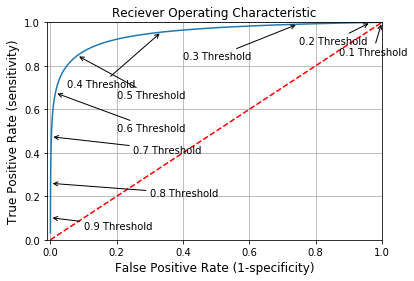

In [15]:
data55 = np.array ([
        [sub_specificity0_x, sensitivity0_y],
        [sub_specificity01_x, sensitivity01_y],
        [sub_specificity02_x, sensitivity02_y],
        [sub_specificity03_x, sensitivity03_y],
        [sub_specificity04_x, sensitivity04_y],
        [sub_specificity05_x, sensitivity05_y],
        [sub_specificity06_x, sensitivity06_y],
        [sub_specificity07_x, sensitivity07_y],
        [sub_specificity08_x, sensitivity08_y],
        [sub_specificity09_x, sensitivity09_y],
        [sub_specificity1_x, sensitivity1_y],
        [sub_specificity11_x, sensitivity11_y],
        [sub_specificity12_x, sensitivity12_y],
        [sub_specificity13_x, sensitivity13_y],
        [sub_specificity14_x, sensitivity14_y],
        [sub_specificity15_x, sensitivity15_y],
        [sub_specificity16_x, sensitivity16_y],
        [sub_specificity17_x, sensitivity17_y],
        [sub_specificity18_x, sensitivity18_y],
        [sub_specificity19_x, sensitivity19_y],
        [sub_specificity2_x, sensitivity2_y],
        [sub_specificity21_x, sensitivity21_y],
        [sub_specificity22_x, sensitivity22_y],
        [sub_specificity23_x, sensitivity23_y],
        [sub_specificity24_x, sensitivity24_y],
        [sub_specificity25_x, sensitivity25_y],
        [sub_specificity26_x, sensitivity26_y],
        [sub_specificity27_x, sensitivity27_y],
        [sub_specificity28_x, sensitivity28_y],
        [sub_specificity29_x, sensitivity29_y],
        [sub_specificity3_x, sensitivity3_y],
        [sub_specificity31_x, sensitivity31_y],
        [sub_specificity32_x, sensitivity32_y],
        [sub_specificity33_x, sensitivity33_y],
        [sub_specificity34_x, sensitivity34_y],
        [sub_specificity35_x, sensitivity35_y],
        [sub_specificity36_x, sensitivity36_y],
        [sub_specificity37_x, sensitivity37_y],
        [sub_specificity38_x, sensitivity38_y],
        [sub_specificity39_x, sensitivity39_y],
        [sub_specificity4_x, sensitivity4_y],
        [sub_specificity41_x, sensitivity41_y],
        [sub_specificity42_x, sensitivity42_y],
        [sub_specificity43_x, sensitivity43_y],
        [sub_specificity44_x, sensitivity44_y],
        [sub_specificity45_x, sensitivity45_y],
        [sub_specificity46_x, sensitivity46_y],
        [sub_specificity47_x, sensitivity47_y],
        [sub_specificity48_x, sensitivity48_y],
        [sub_specificity49_x, sensitivity49_y],
        [sub_specificity5_x, sensitivity5_y],
        [sub_specificity51_x, sensitivity51_y],
        [sub_specificity52_x, sensitivity52_y],
        [sub_specificity53_x, sensitivity53_y],
        [sub_specificity54_x, sensitivity54_y],
        [sub_specificity55_x, sensitivity55_y],
        [sub_specificity56_x, sensitivity56_y],
        [sub_specificity57_x, sensitivity57_y],
        [sub_specificity58_x, sensitivity58_y],
        [sub_specificity59_x, sensitivity59_y],
        [sub_specificity6_x, sensitivity6_y],
        [sub_specificity61_x, sensitivity61_y],
        [sub_specificity62_x, sensitivity62_y],
        [sub_specificity63_x, sensitivity63_y],
        [sub_specificity64_x, sensitivity64_y],
        [sub_specificity65_x, sensitivity65_y],
        [sub_specificity66_x, sensitivity66_y],
        [sub_specificity67_x, sensitivity67_y],
        [sub_specificity68_x, sensitivity68_y],
        [sub_specificity69_x, sensitivity69_y],
        [sub_specificity7_x, sensitivity7_y],
        [sub_specificity71_x, sensitivity71_y],
        [sub_specificity72_x, sensitivity72_y],
        [sub_specificity73_x, sensitivity73_y],
        [sub_specificity74_x, sensitivity74_y],
        [sub_specificity75_x, sensitivity75_y],
        [sub_specificity76_x, sensitivity76_y],
        [sub_specificity77_x, sensitivity77_y],
        [sub_specificity78_x, sensitivity78_y],
        [sub_specificity79_x, sensitivity79_y],
        [sub_specificity8_x, sensitivity8_y],
        [sub_specificity81_x, sensitivity81_y],
        [sub_specificity82_x, sensitivity82_y],
        [sub_specificity83_x, sensitivity83_y],
        [sub_specificity84_x, sensitivity84_y],
        [sub_specificity85_x, sensitivity85_y],
        [sub_specificity86_x, sensitivity86_y],
        [sub_specificity87_x, sensitivity87_y],
        [sub_specificity88_x, sensitivity88_y],
        [sub_specificity89_x, sensitivity89_y], 
        [sub_specificity9_x, sensitivity9_y],
        [sub_specificity91_x, sensitivity91_y],
        [sub_specificity92_x, sensitivity92_y],
        [sub_specificity93_x, sensitivity93_y],
        [sub_specificity94_x, sensitivity94_y],
        [sub_specificity95_x, sensitivity95_y],
        [sub_specificity96_x, sensitivity96_y],
        [sub_specificity97_x, sensitivity97_y],
        [sub_specificity98_x, sensitivity98_y],
        [sub_specificity99_x, sensitivity99_y], 
])
data55
x, y = data55.T
plt.plot(x, y, '-')
plt.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red")

#arrows highlighting where each threshold value is
plt.annotate('0.1 Threshold', xy=(sub_specificity1_x, sensitivity1_y),arrowprops=dict(arrowstyle='->'), xytext=(0.87, 0.85)) 
plt.annotate('0.2 Threshold', xy=(sub_specificity2_x, sensitivity2_y),arrowprops=dict(arrowstyle='->'), xytext=(0.75, 0.9)) 
plt.annotate('0.3 Threshold', xy=(sub_specificity3_x, sensitivity3_y),arrowprops=dict(arrowstyle='->'), xytext=(0.4, 0.83)) 
plt.annotate('0.4 Threshold', xy=(sub_specificity4_x, sensitivity4_y),arrowprops=dict(arrowstyle='->'), xytext=(0.05, 0.7)) 
plt.annotate('0.5 Threshold', xy=(sub_specificity5_x, sensitivity5_y),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.65)) 
plt.annotate('0.6 Threshold', xy=(sub_specificity6_x, sensitivity6_y),arrowprops=dict(arrowstyle='->'), xytext=(0.2, 0.5)) 
plt.annotate('0.7 Threshold', xy=(sub_specificity7_x, sensitivity7_y),arrowprops=dict(arrowstyle='->'), xytext=(0.25, 0.4)) 
plt.annotate('0.8 Threshold', xy=(sub_specificity8_x, sensitivity8_y),arrowprops=dict(arrowstyle='->'), xytext=(0.3, 0.2)) 
plt.annotate('0.9 Threshold', xy=(sub_specificity9_x, sensitivity9_y),arrowprops=dict(arrowstyle='->'), xytext=(0.1, 0.05)) 

#Setting up plot layout
plt.ylim(0, 1)
plt.xlim(-0.01, 1)
plt.grid()
plt.title('Reciever Operating Characteristic')
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.rcParams['figure.figsize'] = (10,10)

plt.show()

# Using Youden's Index to Find the Ideal Classification Threshold

Youden's Index is the point on the ROC curve where sensitivity and specificity are maximized, a maximum difference between TPR and FPR (TPR - FPR). The threshold ranges between 0 and 1. A plot is generated to show the point on the curve where the Youden's Index point is on curve.

In [16]:
#setting the inputs

#100 different CV thresholds used 
thresholds = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
fpr = np.array([sub_specificity0_x, sub_specificity01_x, sub_specificity02_x, sub_specificity03_x, sub_specificity04_x, sub_specificity05_x, sub_specificity06_x, sub_specificity07_x, sub_specificity08_x, sub_specificity09_x, sub_specificity1_x, sub_specificity11_x, sub_specificity12_x, sub_specificity13_x, sub_specificity14_x, sub_specificity15_x, sub_specificity16_x, sub_specificity17_x, sub_specificity18_x, sub_specificity19_x, sub_specificity2_x, sub_specificity21_x, sub_specificity22_x, sub_specificity23_x, sub_specificity24_x, sub_specificity25_x, sub_specificity26_x, sub_specificity27_x, sub_specificity28_x, sub_specificity29_x, sub_specificity3_x, sub_specificity31_x, sub_specificity32_x, sub_specificity33_x, sub_specificity34_x, sub_specificity35_x, sub_specificity36_x, sub_specificity37_x, sub_specificity38_x, sub_specificity39_x, sub_specificity4_x, sub_specificity41_x, sub_specificity42_x, sub_specificity43_x, sub_specificity44_x, sub_specificity45_x, sub_specificity46_x, sub_specificity47_x, sub_specificity48_x, sub_specificity49_x, sub_specificity5_x, sub_specificity51_x, sub_specificity52_x, sub_specificity53_x, sub_specificity54_x, sub_specificity55_x, sub_specificity56_x, sub_specificity57_x, sub_specificity58_x, sub_specificity59_x, sub_specificity6_x, sub_specificity61_x, sub_specificity62_x, sub_specificity63_x, sub_specificity64_x, sub_specificity65_x, sub_specificity66_x, sub_specificity67_x, sub_specificity68_x, sub_specificity69_x, sub_specificity7_x, sub_specificity71_x, sub_specificity72_x, sub_specificity73_x, sub_specificity74_x, sub_specificity75_x, sub_specificity76_x, sub_specificity77_x, sub_specificity78_x, sub_specificity79_x, sub_specificity8_x, sub_specificity81_x, sub_specificity82_x, sub_specificity83_x, sub_specificity84_x, sub_specificity85_x, sub_specificity86_x, sub_specificity87_x, sub_specificity88_x, sub_specificity89_x, sub_specificity9_x, sub_specificity91_x, sub_specificity92_x, sub_specificity93_x, sub_specificity94_x, sub_specificity95_x, sub_specificity96_x, sub_specificity97_x, sub_specificity98_x, sub_specificity99_x])
tpr = np.array([sensitivity0_y, sensitivity01_y, sensitivity02_y, sensitivity03_y, sensitivity04_y, sensitivity05_y, sensitivity06_y, sensitivity07_y, sensitivity08_y, sensitivity09_y, sensitivity1_y, sensitivity11_y, sensitivity12_y, sensitivity13_y, sensitivity14_y, sensitivity15_y, sensitivity16_y, sensitivity17_y, sensitivity18_y, sensitivity19_y, sensitivity2_y, sensitivity21_y, sensitivity22_y, sensitivity23_y, sensitivity24_y, sensitivity25_y, sensitivity26_y, sensitivity27_y, sensitivity28_y, sensitivity29_y, sensitivity3_y, sensitivity31_y, sensitivity32_y, sensitivity33_y, sensitivity34_y, sensitivity35_y, sensitivity36_y, sensitivity37_y, sensitivity38_y, sensitivity39_y, sensitivity4_y, sensitivity41_y, sensitivity42_y, sensitivity43_y, sensitivity44_y, sensitivity45_y, sensitivity46_y, sensitivity47_y, sensitivity48_y, sensitivity49_y, sensitivity5_y, sensitivity51_y, sensitivity52_y, sensitivity53_y, sensitivity54_y, sensitivity55_y, sensitivity56_y, sensitivity57_y, sensitivity58_y, sensitivity59_y, sensitivity6_y, sensitivity61_y, sensitivity62_y, sensitivity63_y, sensitivity64_y, sensitivity65_y, sensitivity66_y, sensitivity67_y, sensitivity68_y, sensitivity69_y, sensitivity7_y, sensitivity71_y, sensitivity72_y, sensitivity73_y, sensitivity74_y, sensitivity75_y, sensitivity76_y, sensitivity77_y, sensitivity78_y, sensitivity79_y, sensitivity8_y, sensitivity81_y, sensitivity82_y, sensitivity83_y, sensitivity84_y, sensitivity85_y, sensitivity86_y, sensitivity87_y, sensitivity88_y, sensitivity89_y, sensitivity9_y, sensitivity91_y, sensitivity92_y, sensitivity93_y, sensitivity94_y, sensitivity95_y, sensitivity96_y, sensitivity97_y, sensitivity98_y, sensitivity99_y])

#finding the threshold value with the greatest difference between TPR and FPR (x and y axes)
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

best_thresh = cutoff_youdens_j(fpr,tpr,thresholds)
print (best_thresh)

0.49


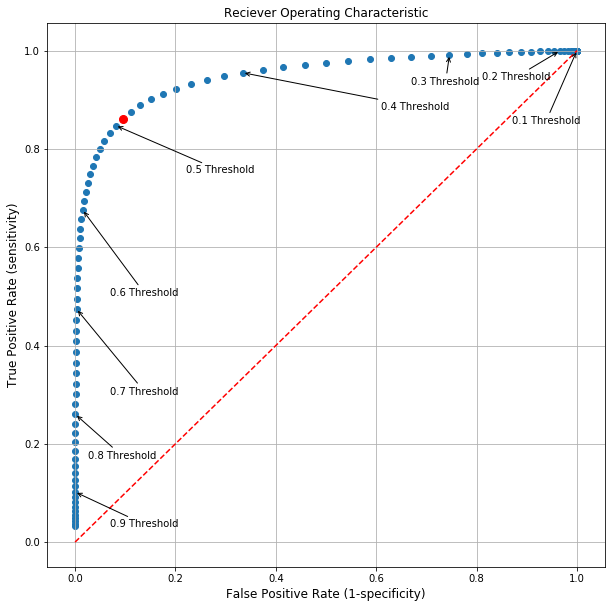

<Figure size 720x720 with 0 Axes>

In [17]:
#displays Youden's Index calculated point on cure 

best_thresh_index = thresholds.index(best_thresh)
fpr_specificity_ideal = fpr[best_thresh_index] 
tpr_sensitivity_ideal = tpr[best_thresh_index]

data100 = np.array ([
        [sub_specificity0_x, sensitivity0_y],
        [sub_specificity01_x, sensitivity01_y],
        [sub_specificity02_x, sensitivity02_y],
        [sub_specificity03_x, sensitivity03_y],
        [sub_specificity04_x, sensitivity04_y],
        [sub_specificity05_x, sensitivity05_y],
        [sub_specificity06_x, sensitivity06_y],
        [sub_specificity07_x, sensitivity07_y],
        [sub_specificity08_x, sensitivity08_y],
        [sub_specificity09_x, sensitivity09_y],
        [sub_specificity1_x, sensitivity1_y],
        [sub_specificity11_x, sensitivity11_y],
        [sub_specificity12_x, sensitivity12_y],
        [sub_specificity13_x, sensitivity13_y],
        [sub_specificity14_x, sensitivity14_y],
        [sub_specificity15_x, sensitivity15_y],
        [sub_specificity16_x, sensitivity16_y],
        [sub_specificity17_x, sensitivity17_y],
        [sub_specificity18_x, sensitivity18_y],
        [sub_specificity19_x, sensitivity19_y],
        [sub_specificity2_x, sensitivity2_y],
        [sub_specificity21_x, sensitivity21_y],
        [sub_specificity22_x, sensitivity22_y],
        [sub_specificity23_x, sensitivity23_y],
        [sub_specificity24_x, sensitivity24_y],
        [sub_specificity25_x, sensitivity25_y],
        [sub_specificity26_x, sensitivity26_y],
        [sub_specificity27_x, sensitivity27_y],
        [sub_specificity28_x, sensitivity28_y],
        [sub_specificity29_x, sensitivity29_y],
        [sub_specificity3_x, sensitivity3_y],
        [sub_specificity31_x, sensitivity31_y],
        [sub_specificity32_x, sensitivity32_y],
        [sub_specificity33_x, sensitivity33_y],
        [sub_specificity34_x, sensitivity34_y],
        [sub_specificity35_x, sensitivity35_y],
        [sub_specificity36_x, sensitivity36_y],
        [sub_specificity37_x, sensitivity37_y],
        [sub_specificity38_x, sensitivity38_y],
        [sub_specificity39_x, sensitivity39_y],
        [sub_specificity4_x, sensitivity4_y],
        [sub_specificity41_x, sensitivity41_y],
        [sub_specificity42_x, sensitivity42_y],
        [sub_specificity43_x, sensitivity43_y],
        [sub_specificity44_x, sensitivity44_y],
        [sub_specificity45_x, sensitivity45_y],
        [sub_specificity46_x, sensitivity46_y],
        [sub_specificity47_x, sensitivity47_y],
        [sub_specificity48_x, sensitivity48_y],
        [sub_specificity49_x, sensitivity49_y],
        [sub_specificity5_x, sensitivity5_y],
        [sub_specificity51_x, sensitivity51_y],
        [sub_specificity52_x, sensitivity52_y],
        [sub_specificity53_x, sensitivity53_y],
        [sub_specificity54_x, sensitivity54_y],
        [sub_specificity55_x, sensitivity55_y],
        [sub_specificity56_x, sensitivity56_y],
        [sub_specificity57_x, sensitivity57_y],
        [sub_specificity58_x, sensitivity58_y],
        [sub_specificity59_x, sensitivity59_y],
        [sub_specificity6_x, sensitivity6_y],
        [sub_specificity61_x, sensitivity61_y],
        [sub_specificity62_x, sensitivity62_y],
        [sub_specificity63_x, sensitivity63_y],
        [sub_specificity64_x, sensitivity64_y],
        [sub_specificity65_x, sensitivity65_y],
        [sub_specificity66_x, sensitivity66_y],
        [sub_specificity67_x, sensitivity67_y],
        [sub_specificity68_x, sensitivity68_y],
        [sub_specificity69_x, sensitivity69_y],
        [sub_specificity7_x, sensitivity7_y],
        [sub_specificity71_x, sensitivity71_y],
        [sub_specificity72_x, sensitivity72_y],
        [sub_specificity73_x, sensitivity73_y],
        [sub_specificity74_x, sensitivity74_y],
        [sub_specificity75_x, sensitivity75_y],
        [sub_specificity76_x, sensitivity76_y],
        [sub_specificity77_x, sensitivity77_y],
        [sub_specificity78_x, sensitivity78_y],
        [sub_specificity79_x, sensitivity79_y],
        [sub_specificity8_x, sensitivity8_y],
        [sub_specificity81_x, sensitivity81_y],
        [sub_specificity82_x, sensitivity82_y],
        [sub_specificity83_x, sensitivity83_y],
        [sub_specificity84_x, sensitivity84_y],
        [sub_specificity85_x, sensitivity85_y],
        [sub_specificity86_x, sensitivity86_y],
        [sub_specificity87_x, sensitivity87_y],
        [sub_specificity88_x, sensitivity88_y],
        [sub_specificity89_x, sensitivity89_y], 
        [sub_specificity9_x, sensitivity9_y],
        [sub_specificity91_x, sensitivity91_y],
        [sub_specificity92_x, sensitivity92_y],
        [sub_specificity93_x, sensitivity93_y],
        [sub_specificity94_x, sensitivity94_y],
        [sub_specificity95_x, sensitivity95_y],
        [sub_specificity96_x, sensitivity96_y],
        [sub_specificity97_x, sensitivity97_y],
        [sub_specificity98_x, sensitivity98_y],
        [sub_specificity99_x, sensitivity99_y], 
])
data100
x, y = data100.T
plt.scatter(x, y)
plt.plot([0.0, 1.0], [0.0,1.0], linestyle= "--", color = "red")
plt.plot([fpr_specificity_ideal], [tpr_sensitivity_ideal], marker='o', markersize=8, color="red")

#arrows highlighting where each threshold value is
plt.annotate('0.1 Threshold', xy=(sub_specificity1_x, sensitivity1_y),arrowprops=dict(arrowstyle='->'), xytext=(0.87, 0.85)) 
plt.annotate('0.2 Threshold', xy=(sub_specificity2_x, sensitivity2_y),arrowprops=dict(arrowstyle='->'), xytext=(0.81, 0.94)) 
plt.annotate('0.3 Threshold', xy=(sub_specificity3_x, sensitivity3_y),arrowprops=dict(arrowstyle='->'), xytext=(0.67, 0.93)) 
plt.annotate('0.4 Threshold', xy=(sub_specificity4_x, sensitivity4_y),arrowprops=dict(arrowstyle='->'), xytext=(0.61, 0.88)) 
plt.annotate('0.5 Threshold', xy=(sub_specificity5_x, sensitivity5_y),arrowprops=dict(arrowstyle='->'), xytext=(0.22, 0.75)) 
plt.annotate('0.6 Threshold', xy=(sub_specificity6_x, sensitivity6_y),arrowprops=dict(arrowstyle='->'), xytext=(0.07, 0.5)) 
plt.annotate('0.7 Threshold', xy=(sub_specificity7_x, sensitivity7_y),arrowprops=dict(arrowstyle='->'), xytext=(0.07, 0.3)) 
plt.annotate('0.8 Threshold', xy=(sub_specificity8_x, sensitivity8_y),arrowprops=dict(arrowstyle='->'), xytext=(0.025, 0.17)) 
plt.annotate('0.9 Threshold', xy=(sub_specificity9_x, sensitivity9_y),arrowprops=dict(arrowstyle='->'), xytext=(0.07, 0.03)) 

#Setting plot layout
plt.grid()
plt.title('Reciever Operating Characteristic')
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.rcParams['figure.figsize'] = (10,10)

plt.show()

# Finding the AUC

Area Under the ROC curve (AUC) is a performance measurement (between 0 and 1) describing the discrimination power between the crop and non-crop classes. The higher the AUC value the better the model is at separating the two classes. An AUC value of 0.5 signifies there is no distinguishability between the classes. 

In [18]:
AUC = (round(sklearn.metrics.auc(fpr, tpr, reorder= 'deprecated'), 2))
print ("Area Under Curve (AUC):", AUC)

Area Under Curve (AUC): 0.95


# Generating Classified Image Using Youden's Index Optimal Threshold 

Creates a crop/non-crop clssification based on the Youden's Index threshold and displays the image.

In [19]:
#Classify image using the Youden's Index Optimal Threshold
CV_reclass_ideal = np.copy(CV)
CV_reclass_ideal[np.where(CV_reclass_ideal>= best_thresh)] = 1
CV_reclass_ideal[np.where(CV_reclass_ideal< best_thresh)] = 0
CVideal_water = np.subtract(CV_reclass_ideal, watermask)
CVideal_crop_non = np.copy(CVideal_water)
CVideal_crop_non[np.where(CVideal_crop_non>0)] = 1
CVideal_crop_non[np.where(CVideal_crop_non<=0)] = -10
CDL_CVideal = np.subtract(CDL_binary, CVideal_crop_non)

Displaying binary crop/non-crop classification.

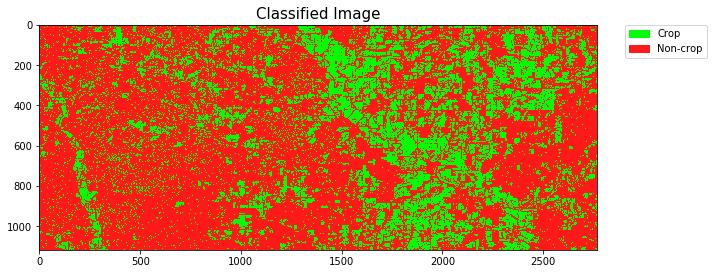

In [30]:
arrayLucc = CV_reclass_ideal
#define the color map and value name as a dictionary
t = 1 ## alpha value
cmap = {1:[0.0,1.0,0.0,t],0:[1.0,0.1,0.1,t]}
labels = {1:'Crop',0:'Non-crop'}
arrayShow = np.array([[cmap[i] for i in j] for j in arrayLucc])    
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.title('Classified Image', fontsize=15)
plt.imshow(arrayShow)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

Displaying crop/non-crop classification with mask and CDL accuracy check included.

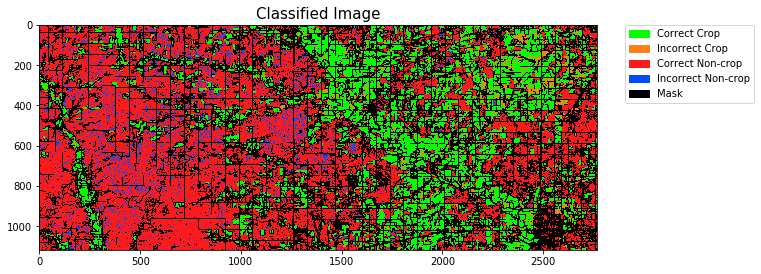

In [33]:
#For classification display where maked values are 

CDL_CVideal_with_mask = CDL_CVideal + watermask
CDL_CVideal_with_mask_rc = np.copy(CDL_CVideal_with_mask)
CDL_CVideal_with_mask_rc[np.where(watermask== 111)]= 100 

#arrayLucc is the array of classified classes
arrayLucc = CDL_CVideal_with_mask_rc
#define the color map and value name as a dictionary
t = 1 ## alpha value
cmap = {0:[0.0,1.0,0.0,t],11:[1.0,0.5,0.1,t],10:[1.0,0.1,0.1,t],-1:[0,0.3,1.0,t],100:[0,0,0,t]}
labels = {0:'Correct Crop',11:'Incorrect Crop',10:'Correct Non-crop',-1:'Incorrect Non-crop',100:'Mask'}
arrayShow = np.array([[cmap[i] for i in j] for j in arrayLucc])    
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

plt.title('Classified Image', fontsize=15)
plt.imshow(arrayShow)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

# Getting Accuracy Statictics for the Youden's Index Optimal Threshold

1. Returns the J-statistic for the determined threshold (maximum difference value between TPR and FPR ranging between 0 and 1)
2. Get percent crop and non-crop classified correctly and incorrectly
3. Get User's and Producer's accuracy of the classification for both crop and non-crop classes
4. Calculate the Kapppa Coefficient = the measure of the agreement between the SAR imagery derived classification and the CDL
    Kappa = (total pixel x total correct pixel - sum of the products)/(total pixel^2 - sum of products)
    Sum of products = sum of row total x column total 
        Interpreting Kappa Statistic: 
         < 0.20          = Poor agreement 
         0.20 - 0.40     = Fair agreement 
         0.40 - 0.60     = Moderate agreement 
         0.60 - 0.80     = Good agreement 
         0.80 - 1.00     = Very good agreement

In [34]:
#Determining the J-statistic calculated by finding the maximum difference between the TPR and FPR
j_scores = tpr-fpr
j_ordered = sorted(zip(j_scores,thresholds))
j_statistic = (round(j_ordered[-1][0], 2))

#Getting statistics on the accuracy of the CV classification using Youden's Index optimal threshold based on CDL classifications
print ('Statistics of accuracy of using CV to classify crop vs non-crop based on CDL:')
p_crop_correct = np.count_nonzero(CDL_CVideal == 0)/(cdl0)
p_crop_correct1 = (round((p_crop_correct*100), 2))
print ('% correct crop: ',p_crop_correct1)
p_non_correct = (np.count_nonzero(CDL_CVideal == 10)-cdl111)/(cdl0)
p_non_correct1 = (round((p_non_correct)*100, 2))
print ('% correct non-crop: ', p_non_correct1)
p_crop_incorrect = np.count_nonzero(CDL_CVideal == 11)/(cdl0)
p_crop_incorrect1 = (round((p_crop_incorrect)*100, 2))  
print ('% incorrect crop: ', p_crop_incorrect1)
p_non_incorrect = np.count_nonzero(CDL_CVideal == -1)/(cdl0)
p_non_incorrect1 = (round((p_non_incorrect)*100, 2))    
print ('% incorrect non-crop: ', p_non_incorrect1)

#Getting Overall Accuracy statistics of the CV classification using Youden's Index optimal threshold based on CDL classifications
print ('Statistics of overall accuracy of using CV to classify crop vs non-crop based on CDL')
p_overall_correct = round((p_crop_correct + p_non_correct)*100, 2)
print ('% overall correct: ', p_overall_correct)
p_overall_incorrect = round((p_crop_incorrect + p_non_incorrect)*100, 2)
print ('% overall incorrect: ', p_overall_incorrect)

#Getting user's and producer's accuracy of the CV classification based on CDL classifications
print ('Users and producers accuracy statistics:')
crop_correct = np.count_nonzero(CDL_CVideal == 0)
non_correct = np.count_nonzero(CDL_CVideal == 10)
crop_incorrect = np.count_nonzero(CDL_CVideal == 11)
non_incorrect = np.count_nonzero(CDL_CVideal == -1)

crop_producers_total = crop_correct + crop_incorrect
non_producers_total = (non_correct - cdl111) + non_incorrect

crop_users_total = crop_correct + non_incorrect
non_users_total = (non_correct - cdl111) + crop_incorrect

crop_p_accuracy = round((crop_correct/crop_producers_total)*100, 2)
print ('% crop producers accuracy: ', crop_p_accuracy)
non_p_accuracy = round(((non_correct - cdl111)/non_producers_total)*100, 2)
print('% non-crop producers accuracy: ', non_p_accuracy)

crop_u_accuracy = round((crop_correct/crop_users_total)*100, 2)
print ('% crop users accuracy: ', crop_u_accuracy)
non_u_accuracy = round(((non_correct - cdl111)/non_users_total)*100, 2)
print ('% non-crop users accuracy: ', non_u_accuracy)

#Calculating Kappa Coefficient
Total_correct = np.count_nonzero(CDL_CVideal == 0) + (np.count_nonzero(CDL_CVideal == 10) - cdl111)

Total_pixel_count = (cdl0)

Sum_of_products_crop_row = np.count_nonzero(CDL_CVideal == 0) + np.count_nonzero(CDL_CVideal == -1)
Sum_of_products_non_row = (np.count_nonzero(CDL_CVideal == 10) - cdl111) + np.count_nonzero(CDL_CVideal == 11)
Sum_of_products_crop_col = np.count_nonzero(CDL_CVideal == 0) + np.count_nonzero(CDL_CVideal == 11)
Sum_of_products_non_col = (np.count_nonzero(CDL_CVideal == 10) - cdl111) + np.count_nonzero(CDL_CVideal == -1)

Sum_of_products = (Sum_of_products_crop_row * Sum_of_products_crop_col) + (Sum_of_products_non_row * Sum_of_products_non_col)

Kappa_coefficient = round((Total_pixel_count * Total_correct - Sum_of_products) / (Total_pixel_count * Total_pixel_count - Sum_of_products), 2)
print ('Kappa Coefficient: ', Kappa_coefficient)

if Kappa_coefficient <= 0.2:
    print ('Poor agreement')
else:
    if Kappa_coefficient <= 0.4:
        print ('Fair agreement')
    else:
        if Kappa_coefficient <= 0.6:
            print ('Moderate agreement')
        else: 
            if Kappa_coefficient <= 0.8:
                print ('Good agreement')
            else: 
                if Kappa_coefficient > 0.8:
                    print ('Very good agreement')

Statistics of accuracy of using CV to classify crop vs non-crop based on CDL:
% correct crop:  26.49
% correct non-crop:  62.67
% incorrect crop:  4.25
% incorrect non-crop:  6.59
Statistics of overall accuracy of using CV to classify crop vs non-crop based on CDL
% overall correct:  89.17
% overall incorrect:  10.83
Users and producers accuracy statistics:
% crop producers accuracy:  86.19
% non-crop producers accuracy:  90.49
% crop users accuracy:  80.08
% non-crop users accuracy:  93.66
Kappa Coefficient:  0.75
Good agreement


# Exporting Accuracy Results

Writes the calculated accuracy results to an excel CSV file to the set output directory. 

In [35]:
#Exporting accuracy statistics as a CSV file

l0 = [best_thresh]
l1 = [p_overall_correct]
l2 = [p_crop_correct1]
l3 = [p_non_correct1]
l4 = [p_crop_incorrect1]
l5 = [p_non_incorrect1]
l6 = [crop_p_accuracy]
l7 = [non_p_accuracy]
l8 = [crop_u_accuracy]
l9 = [non_u_accuracy]
l10 = [Kappa_coefficient]
l11 = [j_statistic]
l12 = [AUC]

df = pd.DataFrame({"Threshold": l0, "Overall Correct": l1, "% crop correct": l2, "% non-crop correct": l3, "% crop incorrect": l4, "% non-crop incorrect": l5, "% Crop Producers Accuracy": l6, "% Non-crop Producers Accuarcy": l7, "% Crop Users Accuracy":l8, "% Non-crop Users Accuracy": l9, "Kappa Coefficient": l10, "J-statistic": l11, "AUC": l12})

os.chdir(Output_folder)

df.to_csv(Accuracy_results)

df

,Threshold,Overall Correct,% crop correct,% non-crop correct,% crop incorrect,% non-crop incorrect,% Crop Producers Accuracy,% Non-crop Producers Accuarcy,% Crop Users Accuracy,% Non-crop Users Accuracy,Kappa Coefficient,J-statistic,AUC
0,0.49,89.17,26.49,62.67,4.25,6.59,86.19,90.49,80.08,93.66,0.75,0.77,0.95


# Exporting the Classified Image

Writes the array to a geotiff that is classified by the Youden's Index ideal threshold based on CV to the set output directory. 


0 = Crop correct

10 = Non-crop correct

11 = Crop Incorrect

-1 = Non-crop Incorrect

(100 = masked values in calcualtion)

In [36]:
# Define write_geotiff function - writes an array to a geotiff
def write_geotiff_export(image, geotrans, cols, rows, spatial_ref, nodata, outfilename):    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(outfilename, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform(geotrans)
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(image)
    outRasterSRS = osr.SpatialReference()
    outband.SetNoDataValue(np.nan)
    outRasterSRS.ImportFromWkt(spatial_ref)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
        
os.chdir(Output_folder)

#Exports binary classification 

write_geotiff_export(CV_reclass_ideal, geotransform, cols, rows, spatialref, np.nan, CV_classification_binary)

#Exports classification with mask and accuracy with CDL is included

write_geotiff_export(CDL_CVideal_with_mask_rc, geotransform, cols, rows, spatialref, np.nan, CV_classification_filename_with_accuracy)